# Model Analysis

Look at some basic model attribures like features selected, and examine links between toy example, imatinib and asthma

In [1]:
import pickle
import numpy as np
import pandas as pd
from pathlib import Path

In [2]:
load_dir = Path('../2_pipeline').resolve()
model_name = '15_Final_Model_Training'

nw_dir = load_dir.joinpath('12d_Preprocessing-Abbreviations_and_Biolink', 'out')
hyp_dir = load_dir.joinpath('13c_Model_Prep_Hyperparam_tuning', 'out')
model_dir = load_dir.joinpath(model_name, 'out')

In [3]:
this_name = '16a_Model_results_analysis'
out_dir = load_dir.joinpath(this_name, 'out')
out_dir.mkdir(exist_ok=True, parents=True)

#imat_asth.to_csv(out_dir.joinpath('imat_asth_paths.csv'), index=False)

In [4]:
nodes = pd.read_csv(nw_dir.joinpath('nodes_biolink.csv'), dtype=str)
edges = pd.read_csv(nw_dir.joinpath('edges_biolink.csv'), dtype=str)

In [5]:
best_param = pickle.load(open(hyp_dir.joinpath('best_param.pkl'), 'rb'))

In [6]:
from hetnet_ml.extractor import MatrixFormattedGraph
mg = MatrixFormattedGraph(nodes, edges, 'ChemicalSubstance', 'Disease', max_length=4, w=best_param['w'], n_jobs=30)

Processing node and edge data...
Initializing metagraph...
Generating adjacency matrices...


100%|██████████| 68/68 [00:57<00:00,  1.19it/s]



Determining degrees for each node and metaedge


100%|██████████| 68/68 [00:41<00:00,  1.65it/s]



Weighting matrices by degree with dampening factor 0.5665616931869023...


100%|██████████| 68/68 [00:00<00:00, 114.83it/s]


In [7]:
model = pickle.load(open(model_dir.joinpath('model.pkl'), 'rb'))

/opt/mmayers/software/anaconda3/envs/ml/lib/python3.6/site-packages/data_tools/df_processing.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [8]:
coef = pd.read_csv(model_dir.joinpath('coef.csv'))
mech_mps = pd.read_csv('../0_data/manual/mech_mps.txt', header=None)[0].values

In [9]:
metapaths = coef.query('feature != "intercept"')['feature'].tolist()

In [10]:
from data_tools.graphs import dataframes_to_metagraph, metapaths_to_json
metagraph = dataframes_to_metagraph(nodes, edges)

all_metapaths = metagraph.extract_metapaths('ChemicalSubstance', 'Disease', 4)
mp_info = {mp.abbrev: mp for mp in all_metapaths if mp.abbrev in metapaths}

## Examining the top selected features

In [11]:
pos_coef = coef.query('coef > 0')['feature'].tolist()

In [12]:
coef.query('coef > 0').head(15)

,feature,coef,zcoef
0,CafBPawD,3.735980,0.273837
1,CafGrxCtD,2.335925,0.148932
2,CafGpoBPpoCtD,2.308317,0.146847
3,CafBPawPmCtD,1.983815,0.190773
4,CpoPWpoGrCtD,1.519787,0.055281
5,CinGpoPWawD,1.449461,0.124888
6,CafGpoPWpoCtD,1.294288,0.118364
7,CinGpoPWpoCtD,1.260486,0.114077
8,CinGpoBPitTcD,1.147065,0.057824
9,CinBPawD,1.106648,0.092215


In [13]:
from data_tools import graphs as gt

In [14]:
abv, et = gt.get_abbrev_dict_and_edge_tuples(nodes, edges)

In [15]:
edge_info = pd.read_csv('../0_data/manual/edge_semtypes.csv')
inv_map = edge_info.set_index('fwd_edge')['rev_edge'].to_dict()

In [16]:
for mp in coef.query('coef > 0').head(15)['feature']:
    gt.print_metapath(mp_info[mp], inv_map, lines='one')

(ChemicalSubstance) - [AFFECTS] - (BiologicalProcessOrActivity) - [ASSOCIATED_WITH] - (Disease)
(ChemicalSubstance) - [AFFECTS] - (MacromolecularMachine) - [IN_REACTION_WITH] - (ChemicalSubstance) - [TREATS] - (Disease)
(ChemicalSubstance) - [AFFECTS] - (MacromolecularMachine) - [PART_OF] - (BiologicalProcessOrActivity) - [HAS_PART] - (ChemicalSubstance) - [TREATS] - (Disease)
(ChemicalSubstance) - [AFFECTS] - (BiologicalProcessOrActivity) - [ASSOCIATED_WITH] - (PhenotypicFeature) - [MARKED_BY] - (ChemicalSubstance) - [TREATS] - (Disease)
(ChemicalSubstance) - [PART_OF] - (Pathway) - [HAS_PART] - (MacromolecularMachine) - [REGULATES] - (ChemicalSubstance) - [TREATS] - (Disease)
(ChemicalSubstance) - [INHIBITS] - (MacromolecularMachine) - [PART_OF] - (Pathway) - [ASSOCIATED_WITH] - (Disease)
(ChemicalSubstance) - [AFFECTS] - (MacromolecularMachine) - [PART_OF] - (Pathway) - [HAS_PART] - (ChemicalSubstance) - [TREATS] - (Disease)
(ChemicalSubstance) - [INHIBITS] - (MacromolecularMachine)

In [17]:
msat = model[0]
max_abs = model[1]

In [18]:
ini_means = {f: m for f, m in zip(metapaths, msat.initial_mean_)}
ma_scale = {f: m for f, m in zip(metapaths, max_abs.scale_)}
feat_coef = coef.set_index('feature')['coef'].to_dict()
feat_zcoef = coef.set_index('feature')['zcoef'].to_dict()

In [19]:
node_labels = nodes['label'].unique()

In [20]:
from collections import defaultdict

## Looking at Node Types selected by model

We want to see which node types were selected by the model, to ensure that all are incporated in some fashion into the predictions

In [21]:
found_mps = defaultdict(list)

for row in coef.query('coef > 0').itertuples():
    mp_list = gt.metapath_to_list(mp_info[row.feature])
    found_mps['feature'].append(row.feature)
    for l in node_labels:
        if l in mp_list:
            found_mps[l].append(1)
        else:
            found_mps[l].append(0)
found_mps = pd.DataFrame(found_mps)

In [22]:
from data_tools.plotting import count_plot_h

In [23]:
node_color_map = {'AnatomicalEntity': "#8c88d7",
                'BiologicalProcessOrActivity': "#b75970",
                'MacromolecularMachine': "#e71761",
                'Disease': "#70c6ca",
                'Pathway': "#b1d34f",
                'PhenotypicFeature': "#154e56",
                'GeneFamily': "#5a3386",
                'PhysiologicalProcess': '#ec102f',
                'OrganismTaxon': "#e9bf98",
                'ChemicalSubstance': "#01c472",}

In [24]:
# Imports for plotting results
%matplotlib inline

import networkx as nx
import seaborn as sns
from scipy.spatial import distance
from collections import defaultdict
import matplotlib.pyplot as plt

# networkx throws LOTS of matplotlib warnings when plotting, so we're silencing
import warnings
warnings.simplefilter('ignore')

In [25]:
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

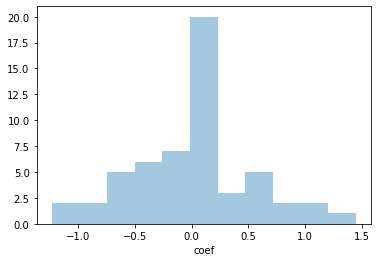

In [26]:
sns.distplot(coef.query('feature in @mech_mps')['coef'], kde=False)


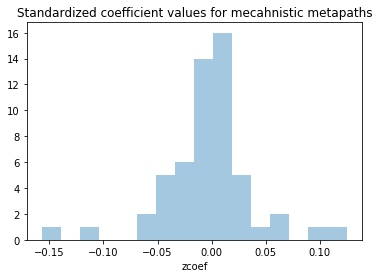

In [27]:
sns.distplot(coef.query('feature in @mech_mps')['zcoef'], kde=False)
plt.title("Standardized coefficient values for mecahnistic metapaths");

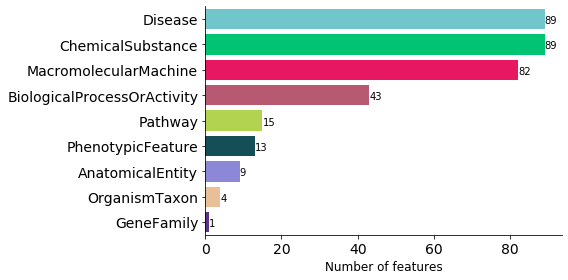

In [28]:
to_plot = found_mps.drop('feature', axis=1).sum().sort_values(ascending=False)
order = to_plot.index

default_pal = sns.color_palette()

this_colors = [node_color_map[l] for l in to_plot.index]

fig = plt.figure(figsize=(8,4))
fig.set_tight_layout(True)

count_plot_h(to_plot, order=order, palette=this_colors, saturation=1)
plt.yticks(size=14)
plt.xlabel('Number of features', size=12)
plt.xticks(size=14)
sns.despine()
plt.savefig(out_dir.joinpath('coef_metanode.pdf'));

In [29]:
coef.query('coef > 0 and feature in @mech_mps')

,feature,coef,zcoef
5,CinGpoPWawD,1.449461,1.248877e-01
8,CinGpoBPitTcD,1.147065,5.782381e-02
9,CinBPawD,1.106648,9.221509e-02
17,CinBPitTcD,0.895034,1.790856e-02
22,CinGmPpsD,0.806721,4.551937e-02
28,CinGrxCmD,0.610118,2.433346e-02
29,CinGmD,0.608036,2.776429e-02
31,CinGpoBPawD,0.548079,5.535227e-02
35,CinGnr>GnrBPawD,0.515218,2.443045e-02
37,CaGnr>GprBPawD,0.505722,3.341495e-02


In [30]:
# Were any features with directed edges selected?
coef[coef['feature'].str.contains('>', regex=False)]

,feature,coef,zcoef
23,CafGr>Gr>GawD,0.791862,0.055346
25,CnrGr>GrCtD,0.706755,0.008850
35,CinGnr>GnrBPawD,0.515218,0.024430
37,CaGnr>GprBPawD,0.505722,0.033415
56,CafG<rGr>GawD,0.293616,0.027755
57,CaGnr>GrxCmD,0.283470,0.004128
71,CaGr>GrCtD,0.171469,0.008089
72,CaGnr>GpoBPawD,0.167894,0.009916
74,CpoPWpoGr>GawD,0.142477,0.005546
79,CinGpr>GpoAawD,0.086991,0.005052


## Examine moldel results

In [31]:
res = pd.read_csv(model_dir.joinpath('results.csv'))
res = res.sort_values('proba', ascending=False).reset_index(drop=True)

len(res)

90996724

In [32]:
id_to_name = nodes.set_index('id')['name'].to_dict()
res['chem_name'] = res['chemicalsubstance_id'].map(id_to_name)
res['dis_name'] = res['disease_id'].map(id_to_name)

res.head(2)

,chemicalsubstance_id,disease_id,status,proba,chem_name,dis_name
0,CHEBI:53769,MONDO:0005399,0,0.997371,(S)-acenocoumarol,venous thromboembolism
1,CHEBI:50438,MONDO:0005399,0,0.997320,phenprocoumon,venous thromboembolism


In [33]:
def get_model_metric(path_df):
    totals = path_df.groupby('metapath')['metric'].sum().to_dict()
    percent_of_total = path_df['metric'] / path_df['metapath'].map(totals)
    
    trans_metric = np.arcsinh(path_df['metapath'].map(totals) / path_df['metapath'].map(ini_means))
    scal_metric = trans_metric / path_df['metapath'].map(ma_scale)
    
    model_metric = scal_metric * path_df['metapath'].map(feat_coef) * percent_of_total
    return model_metric

In [34]:
def get_std_model_metric(path_df):
    
    totals = path_df.groupby('metapath')['metric'].sum().to_dict()
    percent_of_total = path_df['metric'] / path_df['metapath'].map(totals)
    
    trans_metric = np.arcsinh(path_df['metric'] / path_df['metapath'].map(ini_means))
    scal_metric = trans_metric / path_df['metapath'].map(ma_scale)
    
    model_metric = scal_metric * path_df['metapath'].map(feat_zcoef) * percent_of_total
    return model_metric

In [35]:
def get_path_info(compound, disease, n_jobs=30):
    
    path_df = pd.DataFrame(mg.extract_paths(compound, disease, pos_coef, n_jobs=n_jobs))
    path_df['model_metric'] = get_model_metric(path_df)
    path_df['std_metric'] = get_std_model_metric(path_df)
    
    return path_df

In [36]:
def find_nodes_by_name(sub_str, n_type=None):
    if n_type is not None:
        qr = nodes.query('label == @n_type')   
    else:
        qr = nodes
    
    return qr[qr['name'].str.contains(sub_str)]

In [37]:
nodes.loc[nodes[nodes['name'].isnull()].index, 'name'] = nodes.loc[nodes[nodes['name'].isnull()].index, 'id']

### Look for Imatinib

In [38]:
find_nodes_by_name('matinib', n_type='ChemicalSubstance')

,id,name,label,xrefs,source,synonyms,alt_ids,subsets
53986,IKEY:BJCJYEYYYGBROF-UHFFFAOYSA-N,flumatinib,ChemicalSubstance,44methylpiperazin1ylmethyln6methyl54pyridin3yl...,NaN,NaN,NaN,NaN
54301,IKEY:COWBUPJEEDYWKD-UHFFFAOYSA-N,capmatinib dihydrochloride monohydrate,ChemicalSubstance,2fluoronmethyl47quinolin6ylmethylimidazo12b124...,NaN,NaN,NaN,NaN
59724,IKEY:ZTNPHABKLIJXTL-UHFFFAOYSA-N,capmatinib dihydrochloride,ChemicalSubstance,2fluoronmethyl47quinolin6ylmethylimidazo12b124...,NaN,NaN,NaN,NaN
83002,CHEBI:31690,imatinib methanesulfonate,ChemicalSubstance,CHEBI:31690|CHEBI:45783|IKEY:KTUFNOKKBVMGRW-UH...,gvk|informa|integrity,NaN,NaN,NaN
87498,IKEY:ZSASDYCFROUKTJ-UHFFFAOYSA-N,Flumatinib mesylate,ChemicalSubstance,IKEY:ZSASDYCFROUKTJ-UHFFFAOYSA-N|UNII:95Y8L63N...,integrity,NaN,NaN,NaN


### Look for Asthma

In [39]:
find_nodes_by_name('sthma', n_type='Disease')

,id,name,label,xrefs,source,synonyms,alt_ids,subsets
67646,DOID:0040040,hexamethylene diisocyanate allergic asthma,Disease,DOID:0040040,NaN,allergic asthma to HDI|allergic asthma to HMDI,NaN,DO_IEDB_slim
67647,DOID:0040041,isocyanates allergic asthma,Disease,DOID:0040041|MONDO:0025556,NaN,NaN,NaN,DO_IEDB_slim
67648,DOID:0040042,"diphenylmethane-4,4'-diisocyanate allergic asthma",Disease,DOID:0040042,NaN,allergic asthma to MDI,NaN,DO_IEDB_slim
67649,DOID:0040043,toluene meta-diisocyanate allergic asthma,Disease,DOID:0040043,NaN,allergic asthma to TDI,NaN,DO_IEDB_slim
67650,DOID:0040044,methyl isocyanate allergic asthma,Disease,DOID:0040044,NaN,allergic asthma to MIC,NaN,DO_IEDB_slim
67651,DOID:0040045,nickel allergic asthma,Disease,DOID:0040045,NaN,allergic asthma to Ni,NaN,DO_IEDB_slim
67653,DOID:0040047,trimellitic anhydride allergic asthma,Disease,DOID:0040047,NaN,allergic asthma to TMA,NaN,DO_IEDB_slim
67654,DOID:0040048,phthalic anhydride allergic asthma,Disease,DOID:0040048,NaN,NaN,NaN,DO_IEDB_slim
67655,DOID:0040049,maleic anhydride allergic asthma,Disease,DOID:0040049,NaN,allergic asthma to MA,NaN,DO_IEDB_slim
67656,DOID:0040050,tetrachlorophthalic anhydride allergic asthma,Disease,DOID:0040050,NaN,NaN,NaN,DO_IEDB_slim


In [40]:
imat = 'CHEBI:31690'
asth = 'DOID:2841'

In [41]:
imat_asth_res = res.query('chemicalsubstance_id == @imat and disease_id == @asth')
imat_asth_res

,chemicalsubstance_id,disease_id,status,proba,chem_name,dis_name
225935,CHEBI:31690,DOID:2841,0,0.142645,imatinib methanesulfonate,asthma


### Extract paths between Imatinib and Asthma

In [42]:
imat_asth = get_path_info(imat, asth, n_jobs=30)

100%|██████████| 89/89 [01:55<00:00,  1.30s/it]


In [43]:
imat_asth = imat_asth.sort_values('model_metric', ascending=False).reset_index(drop=True)
len(imat_asth)

2581156

Over 6 Million paths connecting these two concepts in our selected metapaths

In [44]:
imat_asth.head(10)

,node_ids,nodes,metapath,metric,model_metric,std_metric
0,"[CHEBI:31690, NCBIGene:5515, DOID:2841]","[imatinib methanesulfonate, PPP2CA, asthma]",CafGmD,0.000194,0.651571,0.034008
1,"[CHEBI:31690, GO:0014827, DOID:2841]","[imatinib methanesulfonate, intestine smooth m...",CafBPawD,0.000012,0.504089,0.028213
2,"[CHEBI:31690, WP:WP3640, NCBIGene:2309, CHEBI:...","[imatinib methanesulfonate, Imatinib and Chron...",CpoPWpoGrCtD,0.000005,0.446197,0.016230
3,"[CHEBI:31690, GO:0070640, DOID:2841]","[imatinib methanesulfonate, vitamin D3 metabol...",CafBPawD,0.000010,0.446079,0.024348
4,"[CHEBI:31690, NCBIGene:1978, MESH:D007249, DOI...","[imatinib methanesulfonate, EIF4EBP1, inflamma...",CinGmPpsD,0.000029,0.353348,0.018861
5,"[CHEBI:31690, GO:0043306, DOID:2841]","[imatinib methanesulfonate, positive regulatio...",CafBPawD,0.000007,0.304037,0.015276
6,"[CHEBI:31690, NCBIGene:217, DOID:2841]","[imatinib methanesulfonate, ALDH2, asthma]",CinGmD,0.000107,0.267511,0.011342
7,"[CHEBI:31690, NCBIGene:1576, CHEBI:3207, DOID:...","[imatinib methanesulfonate, CYP3A4, budesonide...",CafGrxCtD,0.000001,0.267009,0.011738
8,"[CHEBI:31690, NCBIGene:2261, CHEBI:63450, DOID...","[imatinib methanesulfonate, FGFR3, masitinib, ...",CafGrxCtD,0.000001,0.216180,0.008340
9,"[CHEBI:31690, GO:0030199, DOID:2841]","[imatinib methanesulfonate, collagen fibril or...",CafBPawD,0.000005,0.211679,0.009768


In [45]:
imat_asth.query('metapath == "CinGpoBPawD"').head(10)

,node_ids,nodes,metapath,metric,model_metric,std_metric
311,"[CHEBI:31690, NCBIGene:3067, GO:0006548, DOID:...","[imatinib methanesulfonate, HDC, histidine cat...",CinGpoBPawD,1.102054e-06,0.005470,0.000068
407,"[CHEBI:31690, NCBIGene:4835, GO:0003955, DOID:...","[imatinib methanesulfonate, NQO2, NAD(P)H dehy...",CinGpoBPawD,8.587247e-07,0.004262,0.000042
441,"[CHEBI:31690, NCBIGene:3067, GO:0001694, DOID:...","[imatinib methanesulfonate, HDC, histamine bio...",CinGpoBPawD,7.869304e-07,0.003906,0.000035
521,"[CHEBI:31690, NCBIGene:5162, GO:0004738, DOID:...","[imatinib methanesulfonate, PDHB, pyruvate deh...",CinGpoBPawD,6.794333e-07,0.003372,0.000026
862,"[CHEBI:31690, NCBIGene:780, GO:0014909, DOID:2...","[imatinib methanesulfonate, DDR1, smooth muscl...",CinGpoBPawD,3.999779e-07,0.001985,0.000009
880,"[CHEBI:31690, NCBIGene:3815, GO:1904343, DOID:...","[imatinib methanesulfonate, KIT, positive regu...",CinGpoBPawD,3.920683e-07,0.001946,0.000009
923,"[CHEBI:31690, NCBIGene:217, GO:0006069, DOID:2...","[imatinib methanesulfonate, ALDH2, ethanol oxi...",CinGpoBPawD,3.737345e-07,0.001855,0.000008
932,"[CHEBI:31690, NCBIGene:217, GO:0006066, DOID:2...","[imatinib methanesulfonate, ALDH2, alcohol met...",CinGpoBPawD,3.689899e-07,0.001831,0.000008
962,"[CHEBI:31690, NCBIGene:5175, GO:0090673, DOID:...","[imatinib methanesulfonate, PECAM1, endothelia...",CinGpoBPawD,3.558835e-07,0.001766,0.000007
984,"[CHEBI:31690, NCBIGene:217, GO:0043878, DOID:2...","[imatinib methanesulfonate, ALDH2, glyceraldeh...",CinGpoBPawD,3.475407e-07,0.001725,0.000007


### Find the KIT gene, known target for imatinib

In [46]:
find_nodes_by_name('KIT', n_type='MacromolecularMachine')

,id,name,label,xrefs,source,synonyms,alt_ids,subsets
20119,REACT:R-CEL-1433473,"p-KIT (S741,746):PKC alpha",MacromolecularMachine,NaN,NaN,NaN,NaN,NaN
23388,REACT:R-HSA-1433419,PTPRU:KIT,MacromolecularMachine,NaN,NaN,NaN,NaN,NaN
23389,REACT:R-HSA-1433442,SOCS1:p-KIT complex,MacromolecularMachine,NaN,NaN,NaN,NaN,NaN
23390,REACT:R-HSA-1433473,"p-KIT (S741,746):PKC alpha",MacromolecularMachine,NaN,NaN,NaN,NaN,NaN
23391,REACT:R-HSA-1433493,JAK2:SFKS:p-KIT complex,MacromolecularMachine,NaN,NaN,NaN,NaN,NaN
23393,REACT:R-HSA-1433527,p-JAK2:SFKs:p-KIT complex:STATs,MacromolecularMachine,NaN,NaN,NaN,NaN,NaN
23394,REACT:R-HSA-1433530,p-SHP2:p-KIT complex,MacromolecularMachine,NaN,NaN,NaN,NaN,NaN
23395,REACT:R-HSA-1433545,GAB2:GRB2:p-SHP2:p-KIT complex,MacromolecularMachine,NaN,NaN,NaN,NaN,NaN
23396,REACT:R-HSA-1433549,GRB2:p-SHP2:p-KIT complex,MacromolecularMachine,NaN,NaN,NaN,NaN,NaN
23397,REACT:R-HSA-1433552,p-JAK2:SFKs:p-KIT complex,MacromolecularMachine,NaN,NaN,NaN,NaN,NaN


In [47]:
ckit = 'NCBIGene:3815'

In [48]:
def query_target(path_df, tgt_id):
    tgt_ids = path_df['node_ids'].apply(lambda x: x[1])
    
    idx = tgt_ids == tgt_id
    idx = idx[idx].index
    
    return path_df.loc[idx]

In [49]:
def query_path_pos(path_df, tgt_id, pos=1):
    tgt_ids = path_df['node_ids'].apply(lambda x: x[pos] if len(x) > pos else float('nan'))
    
    idx = tgt_ids == tgt_id
    idx = idx[idx].index
    
    return path_df.loc[idx]

In [50]:
tgt_imat_asth = query_target(imat_asth, ckit)
len(tgt_imat_asth)

1865

In [51]:
tgt_imat_asth.head(10)

,node_ids,nodes,metapath,metric,model_metric,std_metric
197,"[CHEBI:31690, NCBIGene:3815, CL:0000936, GO:00...","[imatinib methanesulfonate, KIT, early lymphoi...",CafGpoAcoBPawD,6.273885e-08,0.008964,0.000282
654,"[CHEBI:31690, NCBIGene:3815, REACT:R-HSA-56632...","[imatinib methanesulfonate, KIT, Diseases of s...",CaGpoPWpoCtD,8.245418e-09,0.002647,0.000046
854,"[CHEBI:31690, NCBIGene:3815, GO:0007260, NCBIG...","[imatinib methanesulfonate, KIT, tyrosine phos...",CafGrBPnrGmD,1.777338e-07,0.002008,0.000033
880,"[CHEBI:31690, NCBIGene:3815, GO:1904343, DOID:...","[imatinib methanesulfonate, KIT, positive regu...",CinGpoBPawD,3.920683e-07,0.001946,0.000009
891,"[CHEBI:31690, NCBIGene:3815, CL:0000097, GO:00...","[imatinib methanesulfonate, KIT, mast cell, ma...",CafGpoAcoBPawD,1.346005e-08,0.001923,0.000027
985,"[CHEBI:31690, NCBIGene:3815, GO:1904343, DOID:...","[imatinib methanesulfonate, KIT, positive regu...",CafGpoBPawD,1.655381e-07,0.001724,0.000034
1030,"[CHEBI:31690, NCBIGene:3815, CL:0000097, GO:00...","[imatinib methanesulfonate, KIT, mast cell, hi...",CafGpoAcoBPawD,1.148740e-08,0.001641,0.000020
1032,"[CHEBI:31690, NCBIGene:3815, REACT:R-HSA-88669...","[imatinib methanesulfonate, KIT, TFAP2 (AP-2) ...",CinGpoPWawD,1.335434e-07,0.001641,0.000024
1426,"[CHEBI:31690, NCBIGene:3815, GO:1904343, DOID:...","[imatinib methanesulfonate, KIT, positive regu...",CaGpoBPawD,5.405119e-07,0.001126,0.000042
1743,"[CHEBI:31690, NCBIGene:3815, CL:0000097, GO:00...","[imatinib methanesulfonate, KIT, mast cell, pr...",CafGpoAcoBPawD,6.338795e-09,0.000906,0.000007


In [52]:
edge_info = pd.read_csv('../0_data/manual/edge_semtypes.csv')
inv_map = edge_info.set_index('fwd_edge')['rev_edge'].to_dict()

In [53]:
id_to_label = nodes.set_index('id')['label'].to_dict()

In [54]:
from data_tools import combine_nodes_and_edges

In [55]:
c = combine_nodes_and_edges(nodes, edges)

In [56]:
# Choose custom node colors
# node_color_map = {'AnatomicalEntity': '#5252b9',
#                 'BiologicalProcessOrActivity': '#fc99d5',
#                 'MacromolecularMachine': '#d032a3',
#                 'Disease': '#50e316',
#                 'Pathway': '#b7d165',
#                 'PhenotypicFeature': '#165f28',
#                 'GeneFamily': '#6404b7',
#                 'PhysiologicalProcess': '#ec102f',
#                 'OrganismTaxon': '#e9bf98',
#                 'ChemicalSubstance': '#21f0b6'}

node_color_map = {'AnatomicalEntity': "#8c88d7",
                'BiologicalProcessOrActivity': "#b75970",
                'MacromolecularMachine': "#e71761",
                'Disease': "#70c6ca",
                'Pathway': "#b1d34f",
                'PhenotypicFeature': "#154e56",
                'GeneFamily': "#5a3386",
                'PhysiologicalProcess': '#ec102f',
                'OrganismTaxon': "#e9bf98",
                'ChemicalSubstance': "#01c472",}

node_id_to_color = nodes.set_index('id')['label'].map(node_color_map).to_dict()

In [57]:
from data_tools import plotting as gp

#### Treatments for Asthma

In [58]:
imat_subset_res = res.query('disease_id == @asth').reset_index(drop=True)
len(imat_subset_res)

14084

In [59]:
imat_subset_res.query('chemicalsubstance_id == @imat')

,chemicalsubstance_id,disease_id,status,proba,chem_name,dis_name
580,CHEBI:31690,DOID:2841,0,0.142645,imatinib methanesulfonate,asthma


In [60]:
# Imatinibs percentile
1 - ((imat_subset_res.query('chemicalsubstance_id == @imat').index[0]+1) / len(imat_subset_res))

0.9587475149105368

#### Potential indications for Imatinib

In [61]:
asth_subset_res = res.query('chemicalsubstance_id == @imat').reset_index(drop=True)
len(asth_subset_res)

6461

In [62]:
asth_subset_res.query('disease_id == @asth')

,chemicalsubstance_id,disease_id,status,proba,chem_name,dis_name
143,CHEBI:31690,DOID:2841,0,0.142645,imatinib methanesulfonate,asthma


In [63]:
# Asthma's percentile
1 - ((asth_subset_res.query('disease_id == @asth').index[0]+1) / len(asth_subset_res))

0.9777124284166537

In [64]:
res.query('chemicalsubstance_id == @imat and disease_id == @asth')

,chemicalsubstance_id,disease_id,status,proba,chem_name,dis_name
225935,CHEBI:31690,DOID:2841,0,0.142645,imatinib methanesulfonate,asthma


In [65]:
len(res)

90996724

In [66]:
##  Overall percentile
1 - ((res.query('chemicalsubstance_id == @imat and disease_id == @asth').index[0]+1) / len(res))

0.9975170974286942

In [67]:
'{:,}'.format(len(res))

'90,996,724'

## Draw some explainations

In [68]:
def draw_top_paths(path_df, head_num=10, metric='model_metric', poi_idx=None, proba=None):

        
    top_n_paths = path_df.sort_values(metric, ascending=False).head(head_num)

    # Get the list of paths
    list_of_paths = top_n_paths['node_ids'].tolist()
    path_weights = top_n_paths[metric].tolist()

    # Get the edge names
    list_of_edges = []
    for mp in top_n_paths['metapath']:
        list_of_edges.append(gp.parse_metapath_to_edge_names(mp, mp_info, inv_map))


    
    if type(poi_idx) == list:
        ec = []
        for idx in poi_idx:
            poi = path_df.loc[idx, 'node_ids']
            ec.append(gp.highlight_path_of_interest(list_of_paths, poi))
        
        # Take the edges from the first highlighted poi
        edge_color_map = ec[0]
        for ecm in ec[1:]:
            for k, v in ecm.items():
                # Any other highlihted paths get marked
                # seaborn 1 is highlight color.
                if v == sns.color_palette().as_hex()[1]:
                    edge_color_map[k] = v
        
    elif poi_idx is not None:
        path_of_interest = path_df.loc[poi_idx, 'node_ids']
        edge_color_map = gp.highlight_path_of_interest(list_of_paths, path_of_interest)
    else:
        path_of_interest = []
        edge_color_map = gp.highlight_path_of_interest(list_of_paths, path_of_interest)
    
    

    G = gp.build_explanitory_graph(list_of_paths, list_of_edges, path_weights=path_weights, 
                                node_id_to_label=id_to_label, node_id_to_color=node_id_to_color, 
                                edge_id_to_color=edge_color_map, min_dist=3)

    gp.draw_explanitory_graph(G, node_id_to_name=id_to_name, proba=proba, n_paths=10, xscale=17, title=False);

In [69]:
sns.set_palette('muted')

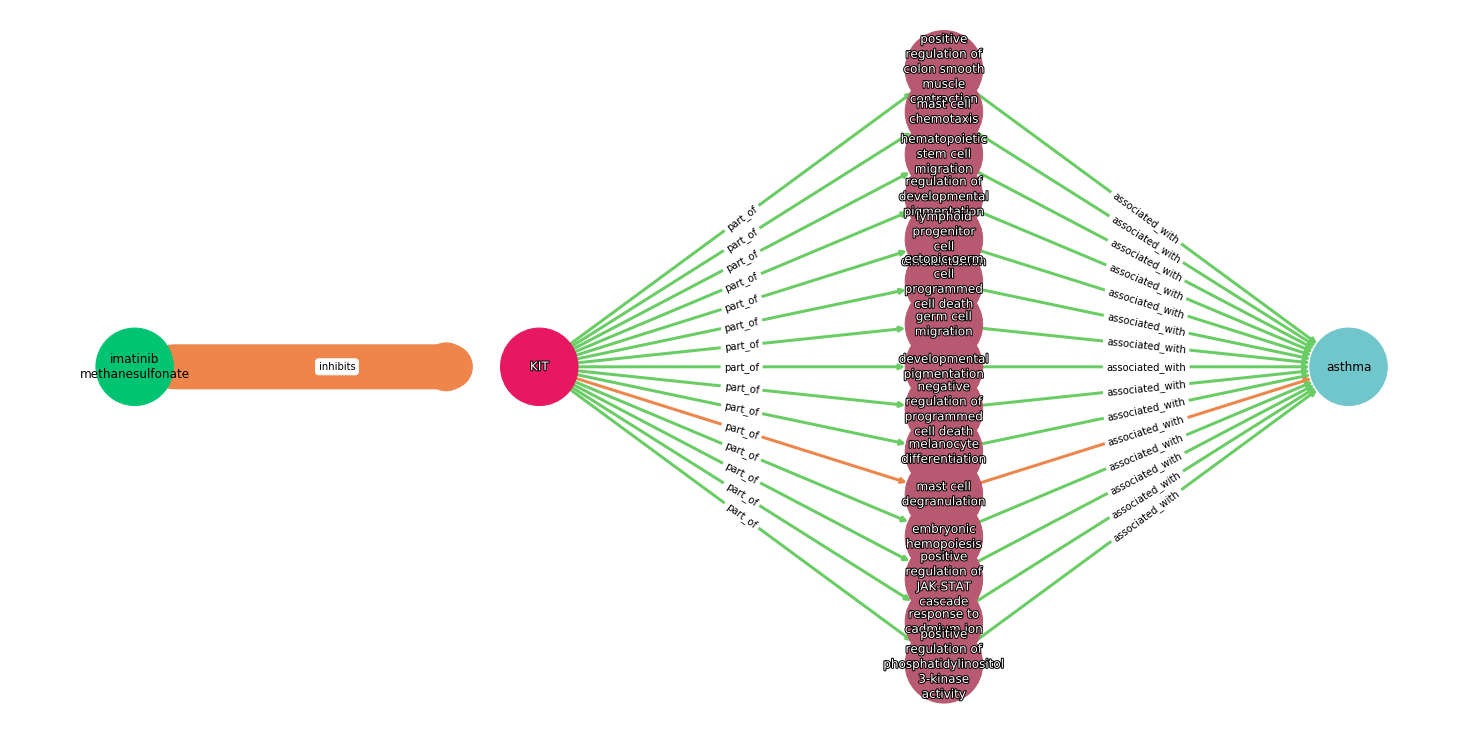

In [70]:
draw_top_paths(tgt_imat_asth.query('metapath == "CinGpoBPawD"'), 15, 'model_metric', poi_idx=9039)
#plt.savefig(out_dir.joinpath('imat_asth_mp.pdf'))

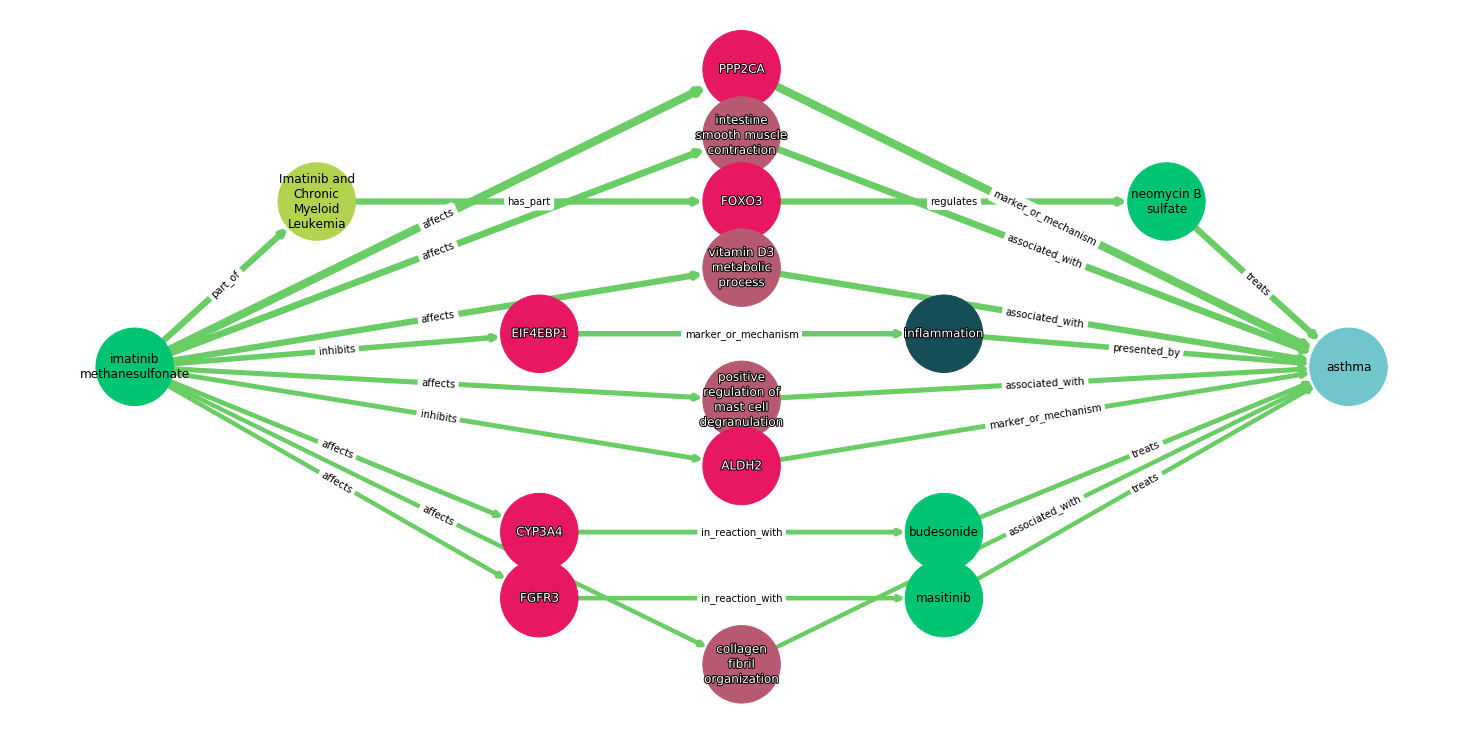

In [71]:
draw_top_paths(imat_asth, 10, 'model_metric')#, poi_idx=5)
#plt.savefig(out_dir.joinpath('imat_asth_top10.pdf'))

In [72]:
tgt_imat_asth.head(10)

,node_ids,nodes,metapath,metric,model_metric,std_metric
197,"[CHEBI:31690, NCBIGene:3815, CL:0000936, GO:00...","[imatinib methanesulfonate, KIT, early lymphoi...",CafGpoAcoBPawD,6.273885e-08,0.008964,0.000282
654,"[CHEBI:31690, NCBIGene:3815, REACT:R-HSA-56632...","[imatinib methanesulfonate, KIT, Diseases of s...",CaGpoPWpoCtD,8.245418e-09,0.002647,0.000046
854,"[CHEBI:31690, NCBIGene:3815, GO:0007260, NCBIG...","[imatinib methanesulfonate, KIT, tyrosine phos...",CafGrBPnrGmD,1.777338e-07,0.002008,0.000033
880,"[CHEBI:31690, NCBIGene:3815, GO:1904343, DOID:...","[imatinib methanesulfonate, KIT, positive regu...",CinGpoBPawD,3.920683e-07,0.001946,0.000009
891,"[CHEBI:31690, NCBIGene:3815, CL:0000097, GO:00...","[imatinib methanesulfonate, KIT, mast cell, ma...",CafGpoAcoBPawD,1.346005e-08,0.001923,0.000027
985,"[CHEBI:31690, NCBIGene:3815, GO:1904343, DOID:...","[imatinib methanesulfonate, KIT, positive regu...",CafGpoBPawD,1.655381e-07,0.001724,0.000034
1030,"[CHEBI:31690, NCBIGene:3815, CL:0000097, GO:00...","[imatinib methanesulfonate, KIT, mast cell, hi...",CafGpoAcoBPawD,1.148740e-08,0.001641,0.000020
1032,"[CHEBI:31690, NCBIGene:3815, REACT:R-HSA-88669...","[imatinib methanesulfonate, KIT, TFAP2 (AP-2) ...",CinGpoPWawD,1.335434e-07,0.001641,0.000024
1426,"[CHEBI:31690, NCBIGene:3815, GO:1904343, DOID:...","[imatinib methanesulfonate, KIT, positive regu...",CaGpoBPawD,5.405119e-07,0.001126,0.000042
1743,"[CHEBI:31690, NCBIGene:3815, CL:0000097, GO:00...","[imatinib methanesulfonate, KIT, mast cell, pr...",CafGpoAcoBPawD,6.338795e-09,0.000906,0.000007


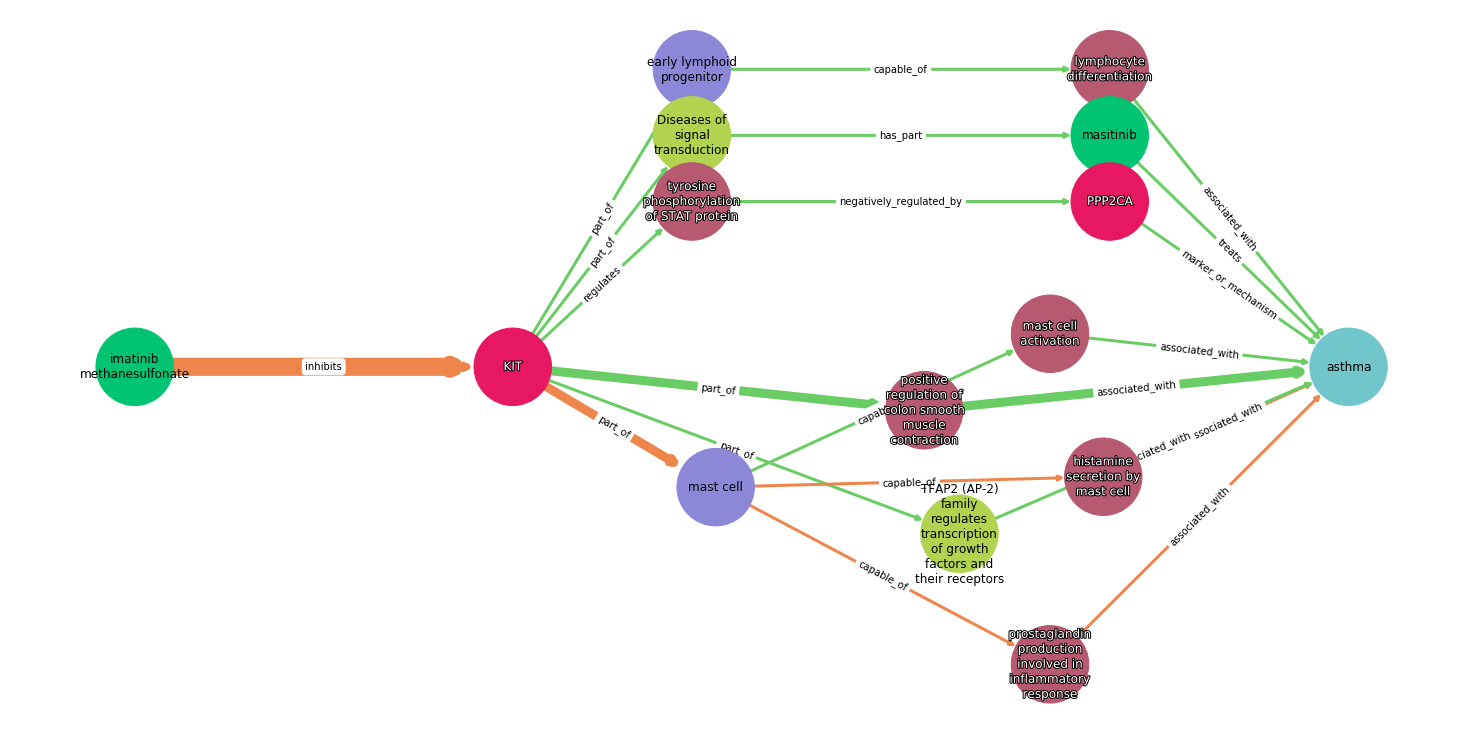

In [73]:
draw_top_paths(tgt_imat_asth, 10, 'model_metric', poi_idx=[1030, 1743])
#plt.savefig(out_dir.joinpath('imat_asth_tgt.pdf'))

In [74]:
c.query('start_name == "HMOX1" and end_name == "asthma"')[['type', 'source', 'dsrc_type', 'pmids']]

,type,source,dsrc_type,pmids
8189497,marker_or_mechanism_GmD,CTD,computed,18048809


In [75]:
mast_bp = ["mast cell degranulation", "mast cell cytokine production"]
c.query('start_name == "HMOX1" and end_name in @mast_bp')[['type', 'source', 'dsrc_type', 'comp_type']]

,type,source,dsrc_type,comp_type
2645420,negatively_regulates_GnrBP,Gene Ontology|WikiData,computed,punning
2645423,negatively_regulates_GnrBP,Gene Ontology|WikiData,computed,punning
8731592,regulates_GrBP,Gene Ontology|WikiData,computed,punning
8731595,regulates_GrBP,Gene Ontology|WikiData,computed,punning


In [76]:
c.query('start_name == "PTEN" and end_name == "asthma"')[['type', 'source', 'dsrc_type', 'pmids']]

,type,source,dsrc_type,pmids
8193055,treats_GtD,CTD,computed,17982072


In [77]:
query_idx = []
for row in tgt_imat_asth.itertuples():
    this_row_nodes = row.nodes
    if this_row_nodes[2] in mast_bp:
        query_idx.append(row.Index)
query_idx

[2977, 9039, 10007, 14079, 15580, 19460, 44448, 59877]

In [78]:
tgt_imat_asth.reset_index().query('index in @query_idx')

,index,node_ids,nodes,metapath,metric,model_metric,std_metric
26,2977,"[CHEBI:31690, NCBIGene:3815, GO:0032762, NCBIG...","[imatinib methanesulfonate, KIT, mast cell cyt...",CafGpoBPrGmD,9.239464e-08,0.000543,2.472425e-06
97,9039,"[CHEBI:31690, NCBIGene:3815, GO:0043303, DOID:...","[imatinib methanesulfonate, KIT, mast cell deg...",CinGpoBPawD,3.678577e-08,0.000183,7.814188e-08
115,10007,"[CHEBI:31690, NCBIGene:3815, GO:0043303, DOID:...","[imatinib methanesulfonate, KIT, mast cell deg...",CafGpoBPawD,1.553160e-08,0.000162,4.207971e-07
169,14079,"[CHEBI:31690, NCBIGene:3815, GO:0043303, DOID:...","[imatinib methanesulfonate, KIT, mast cell deg...",CaGpoBPawD,5.071348e-08,0.000106,1.133087e-06
190,15580,"[CHEBI:31690, NCBIGene:3815, GO:0043303, NCBIG...","[imatinib methanesulfonate, KIT, mast cell deg...",CafGpoBPrGmD,1.561959e-08,0.000092,7.142008e-08
243,19460,"[CHEBI:31690, NCBIGene:3815, GO:0043303, NCBIG...","[imatinib methanesulfonate, KIT, mast cell deg...",CafGpoBPrGmD,1.133229e-08,0.000067,3.759953e-08
589,44448,"[CHEBI:31690, NCBIGene:3815, GO:0043303, HP:00...","[imatinib methanesulfonate, KIT, mast cell deg...",CinGpoBPawPpsD,3.676615e-09,0.000014,2.135894e-09
793,59877,"[CHEBI:31690, NCBIGene:3815, GO:0043303, MESH:...","[imatinib methanesulfonate, KIT, mast cell deg...",CinGpoBPawPpsD,1.801749e-09,0.000007,5.129496e-10


In [79]:
from data_tools import df_processing as dfp

def rank_connecting_nodes(path_df, metric='model_metric'):
    
    first_path = path_df.iloc[0, 0]
    comp_id = first_path[0]
    dis_id = first_path[-1]
    
    metric_vals = path_df[[metric]].reset_index()
    
    # Expand all the nodes
    all_nodes = dfp.expand_split_col(path_df['node_ids'])
    
    # Get the index of each node in the list (this is essential degrees of separation)
    deg_sep = path_df['nodes'].apply(lambda x: list(range(len(x)))).rename('deg_sep')
    deg_sep = dfp.expand_split_col(deg_sep).drop('old_idx', axis=1)
    all_nodes = pd.concat([all_nodes, deg_sep], axis=1)
    
    # Add in each metric for each instance of a node
    all_nodes = all_nodes.merge(metric_vals, left_on=['old_idx'], right_on=['index']).drop(['index', 'old_idx'], axis=1)
    
    # Group on the nodes and add the metrics
    node_metrics = all_nodes.groupby('node_ids')[metric].sum()
    # Get the minimum degress of separation
    deg_sep = all_nodes.groupby('node_ids')['deg_sep'].min()
    
    # Rejoin the metrics and degress of separation and sort.
    all_nodes = pd.concat([node_metrics, deg_sep], axis=1).reset_index().sort_values(metric, ascending=False)
    
    # Filter out the original compound and disease
    all_nodes = all_nodes.query('node_ids != @comp_id and node_ids != @dis_id').reset_index(drop=True)
    all_nodes['node_name'] = all_nodes['node_ids'].map(id_to_name)
    all_nodes['node_label'] = all_nodes['node_ids'].map(id_to_label)
    
    return all_nodes.rename(columns={'node_ids': 'node_id'})

In [80]:
node_ranks = rank_connecting_nodes(imat_asth)

In [81]:
node_ranks.head(10)

,node_id,model_metric,deg_sep,node_name,node_label
0,CHEBI:53636,1.128780,2,neomycin B sulfate,ChemicalSubstance
1,NCBIGene:5515,0.948534,1,PPP2CA,MacromolecularMachine
2,GO:0014827,0.827026,1,intestine smooth muscle contraction,BiologicalProcessOrActivity
3,NCBIGene:5728,0.809209,2,PTEN,MacromolecularMachine
4,GO:0070640,0.754601,1,vitamin D3 metabolic process,BiologicalProcessOrActivity
5,MESH:D007249,0.686585,2,inflammation,PhenotypicFeature
6,NCBIGene:217,0.663397,1,ALDH2,MacromolecularMachine
7,GO:0043306,0.609942,1,positive regulation of mast cell degranulation,BiologicalProcessOrActivity
8,CHEBI:63450,0.542866,2,masitinib,ChemicalSubstance
9,NCBIGene:2309,0.525292,2,FOXO3,MacromolecularMachine


In [82]:
node_ranks.query('deg_sep == 1 and node_label == "MacromolecularMachine"').head(10)

,node_id,model_metric,deg_sep,node_name,node_label
1,NCBIGene:5515,0.948534,1,PPP2CA,MacromolecularMachine
6,NCBIGene:217,0.663397,1,ALDH2,MacromolecularMachine
13,NCBIGene:1978,0.421653,1,EIF4EBP1,MacromolecularMachine
16,NCBIGene:2261,0.352134,1,FGFR3,MacromolecularMachine
19,NCBIGene:1576,0.310806,1,CYP3A4,MacromolecularMachine
22,NCBIGene:2932,0.241150,1,GSK3B,MacromolecularMachine
24,NCBIGene:613,0.225900,1,BCR,MacromolecularMachine
27,NCBIGene:6582,0.219482,1,SLC22A2,MacromolecularMachine
29,NCBIGene:7846,0.210607,1,TUBA1A,MacromolecularMachine
30,NCBIGene:596,0.208687,1,BCL2,MacromolecularMachine


In [83]:
node_ranks.query('deg_sep == 1 and node_label != "MacromolecularMachine"').head(10)

,node_id,model_metric,deg_sep,node_name,node_label
2,GO:0014827,0.827026,1,intestine smooth muscle contraction,BiologicalProcessOrActivity
4,GO:0070640,0.754601,1,vitamin D3 metabolic process,BiologicalProcessOrActivity
7,GO:0043306,0.609942,1,positive regulation of mast cell degranulation,BiologicalProcessOrActivity
10,WP:WP3640,0.511986,1,Imatinib and Chronic Myeloid Leukemia,Pathway
11,GO:0030199,0.505291,1,collagen fibril organization,BiologicalProcessOrActivity
12,GO:0006006,0.466903,1,glucose metabolic process,BiologicalProcessOrActivity
21,GO:0016477,0.267969,1,cell migration,BiologicalProcessOrActivity
25,GO:0045333,0.225249,1,cellular respiration,BiologicalProcessOrActivity
40,GO:0004743,0.167459,1,pyruvate kinase activity,BiologicalProcessOrActivity
41,REACT:R-HSA-1226099,0.160878,1,Signaling by FGFR in disease,Pathway


In [84]:
len(node_ranks.query('deg_sep == 1 and node_label != "MacromolecularMachine"'))

364

In [85]:
node_ranks.query('deg_sep == 2').head(10)

,node_id,model_metric,deg_sep,node_name,node_label
0,CHEBI:53636,1.128780,2,neomycin B sulfate,ChemicalSubstance
3,NCBIGene:5728,0.809209,2,PTEN,MacromolecularMachine
5,MESH:D007249,0.686585,2,inflammation,PhenotypicFeature
8,CHEBI:63450,0.542866,2,masitinib,ChemicalSubstance
9,NCBIGene:2309,0.525292,2,FOXO3,MacromolecularMachine
18,CHEBI:3207,0.325681,2,budesonide,ChemicalSubstance
20,HP:0030828,0.295850,2,Wheezing,PhenotypicFeature
23,HP:0001324,0.237568,2,Muscle weakness,PhenotypicFeature
28,GO:1901374,0.211320,2,acetate ester transport,BiologicalProcessOrActivity
32,GO:0051384,0.197316,2,response to glucocorticoid,BiologicalProcessOrActivity


In [86]:
node_ranks.query('deg_sep == 3').head(10)

,node_id,model_metric,deg_sep,node_name,node_label
14,MESH:D000318,0.371375,3,Adrenergic beta-Agonists,ChemicalSubstance
15,MESH:D009466,0.365320,3,Neuromuscular Blocking Agents,ChemicalSubstance
17,MESH:D005938,0.344644,3,Glucocorticoids,ChemicalSubstance
26,MESH:D015662,0.219852,3,"Trimethoprim, Sulfamethoxazole Drug Combination",ChemicalSubstance
33,CHEBI:95032,0.192885,3,"(6S,9aS)-6-[(4-hydroxyphenyl)methyl]-8-(1-naph...",ChemicalSubstance
47,MESH:D014665,0.136407,3,Vasodilator Agents,ChemicalSubstance
50,CHEBI:3962,0.134005,3,curcumin,ChemicalSubstance
53,MESH:D028321,0.128103,3,Plant Preparations,ChemicalSubstance
65,CHEBI:5615,0.113249,3,halothane,ChemicalSubstance
73,MESH:D004365,0.105684,3,"Drugs, Chinese Herbal",ChemicalSubstance


In [87]:
node_ranks.query('deg_sep == 1 and node_label == "MacromolecularMachine"').reset_index(drop=True).query('node_id == @ckit').head(10)

,node_id,model_metric,deg_sep,node_name,node_label
32,NCBIGene:3815,0.08923,1,KIT,MacromolecularMachine


In [88]:
node_ranks.query('deg_sep == 1 and node_label == "MacromolecularMachine"').reset_index(drop=True).query('node_id ==  "NCBIGene:613"').head(10)

,node_id,model_metric,deg_sep,node_name,node_label
6,NCBIGene:613,0.2259,1,BCR,MacromolecularMachine


In [89]:
41 / 364

0.11263736263736264

In [90]:
from data_tools import df_processing as dfp

In [91]:
def rank_connecting_nodes(path_df, metric='model_metric'):
    
    first_path = path_df.iloc[0, 0]
    comp_id = first_path[0]
    dis_id = first_path[-1]
    
    metric_vals = path_df[[metric]].reset_index()
    
    # Expand all the nodes
    all_nodes = dfp.expand_split_col(path_df['node_ids'])
    
    # Get the index of each node in the list (this is essential degrees of separation)
    deg_sep = path_df['nodes'].apply(lambda x: list(range(len(x)))).rename('deg_sep')
    deg_sep = dfp.expand_split_col(deg_sep).drop('old_idx', axis=1)
    all_nodes = pd.concat([all_nodes, deg_sep], axis=1)
    
    # Add in each metric for each instance of a node
    all_nodes = all_nodes.merge(metric_vals, left_on=['old_idx'], right_on=['index']).drop(['index', 'old_idx'], axis=1)
    
        
    # Group on the nodes and add the metrics
    node_metrics = all_nodes.groupby('node_ids')[metric].sum()
    # Get the minimum degress of separation
    deg_sep = all_nodes.groupby('node_ids')['deg_sep'].min()
    
    # Rejoin the metrics and degress of separation and sort.
    all_nodes = pd.concat([node_metrics, deg_sep], axis=1).reset_index().sort_values(metric, ascending=False)
    
    # Filter out the original compound and disease
    all_nodes = all_nodes.query('node_ids != @comp_id and node_ids != @dis_id').reset_index(drop=True)
    all_nodes['node_name'] = all_nodes['node_ids'].map(id_to_name)
    all_nodes['node_label'] = all_nodes['node_ids'].map(id_to_label)
    
    return all_nodes.rename(columns={'node_ids': 'node_id'})

In [92]:
ranks = rank_connecting_nodes(imat_asth)

In [93]:
ranks.query('node_label == "MacromolecularMachine" and deg_sep == 1').head(10)

,node_id,model_metric,deg_sep,node_name,node_label
1,NCBIGene:5515,0.948534,1,PPP2CA,MacromolecularMachine
6,NCBIGene:217,0.663397,1,ALDH2,MacromolecularMachine
13,NCBIGene:1978,0.421653,1,EIF4EBP1,MacromolecularMachine
16,NCBIGene:2261,0.352134,1,FGFR3,MacromolecularMachine
19,NCBIGene:1576,0.310806,1,CYP3A4,MacromolecularMachine
22,NCBIGene:2932,0.241150,1,GSK3B,MacromolecularMachine
24,NCBIGene:613,0.225900,1,BCR,MacromolecularMachine
27,NCBIGene:6582,0.219482,1,SLC22A2,MacromolecularMachine
29,NCBIGene:7846,0.210607,1,TUBA1A,MacromolecularMachine
30,NCBIGene:596,0.208687,1,BCL2,MacromolecularMachine


In [94]:
sns.set_palette('muted')

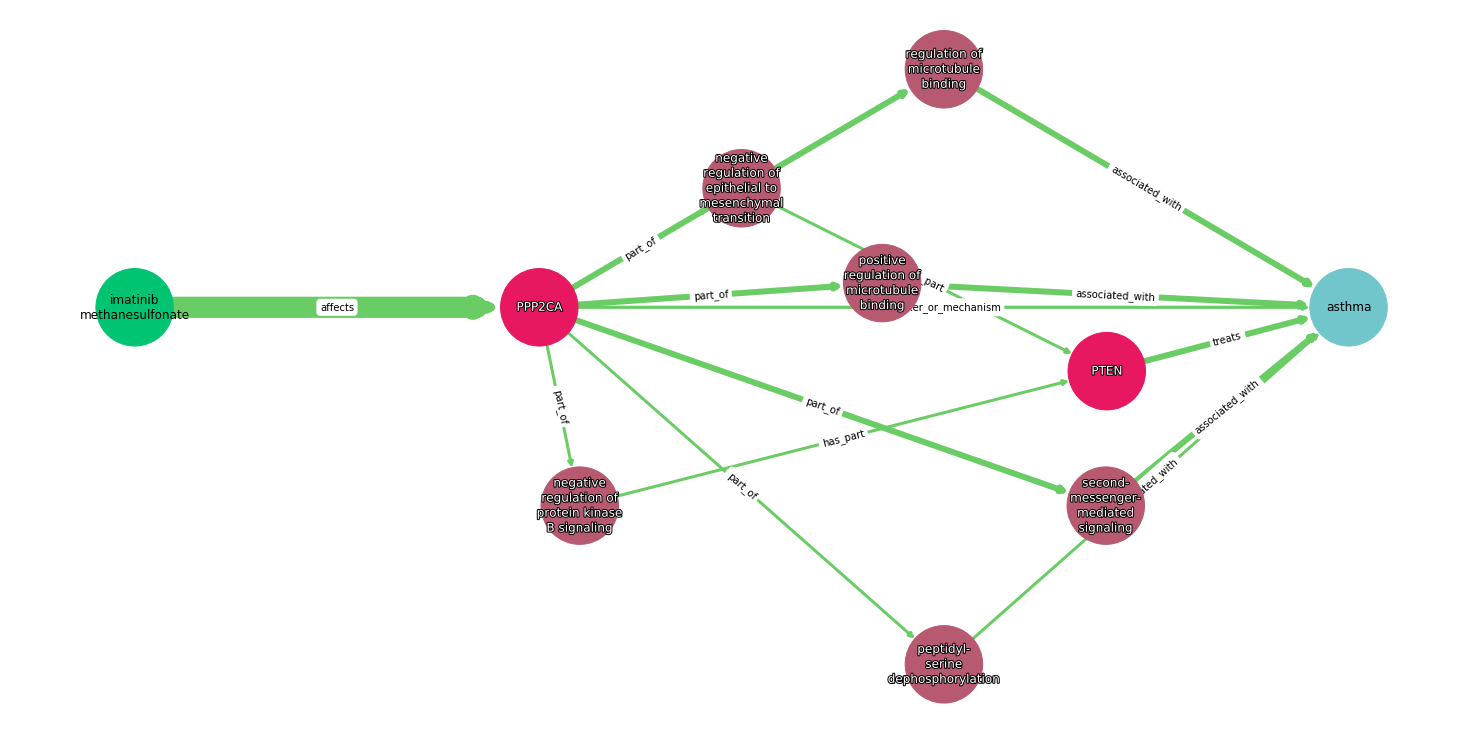

In [95]:
draw_top_paths(query_target(imat_asth, 'NCBIGene:5515'), 10, 'std_metric')

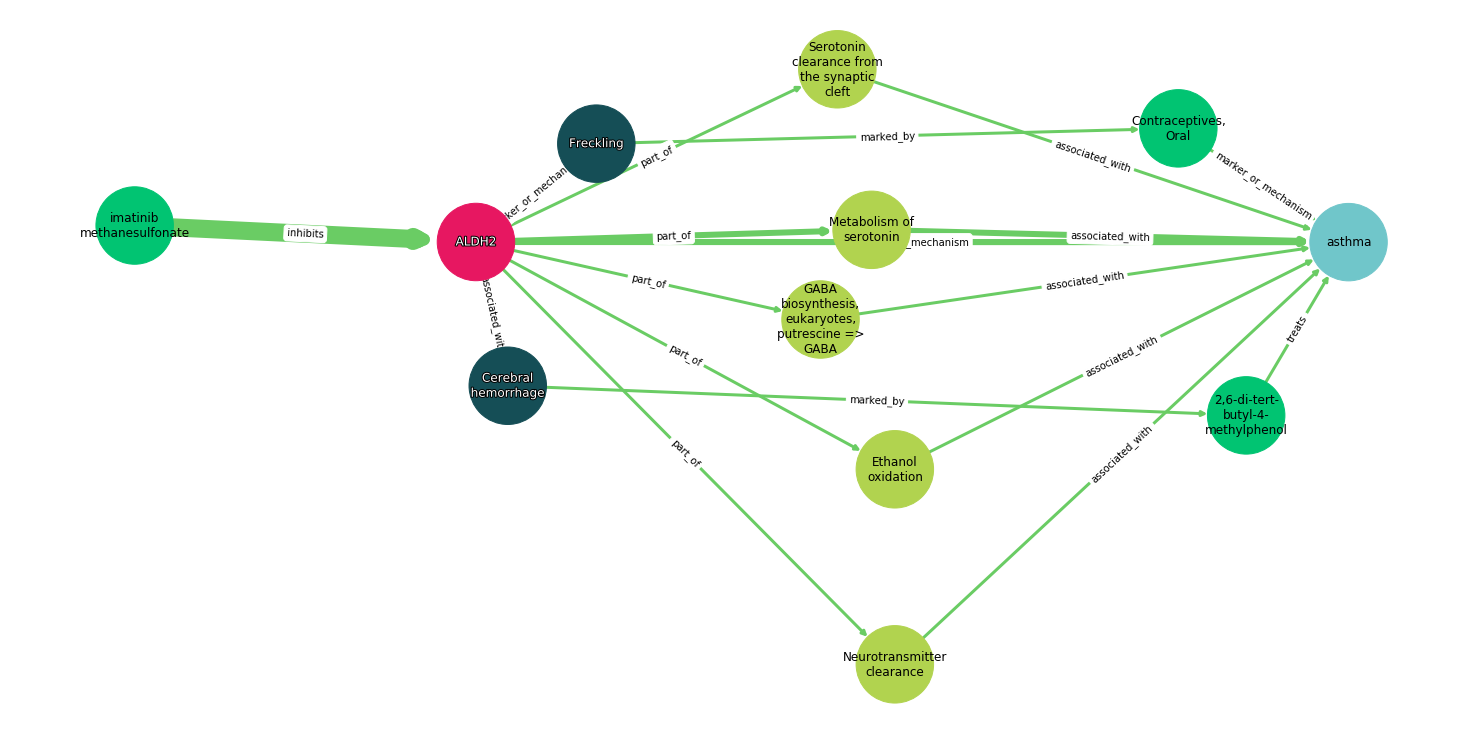

In [96]:
draw_top_paths(query_target(imat_asth, 'NCBIGene:217'), 10, 'std_metric')

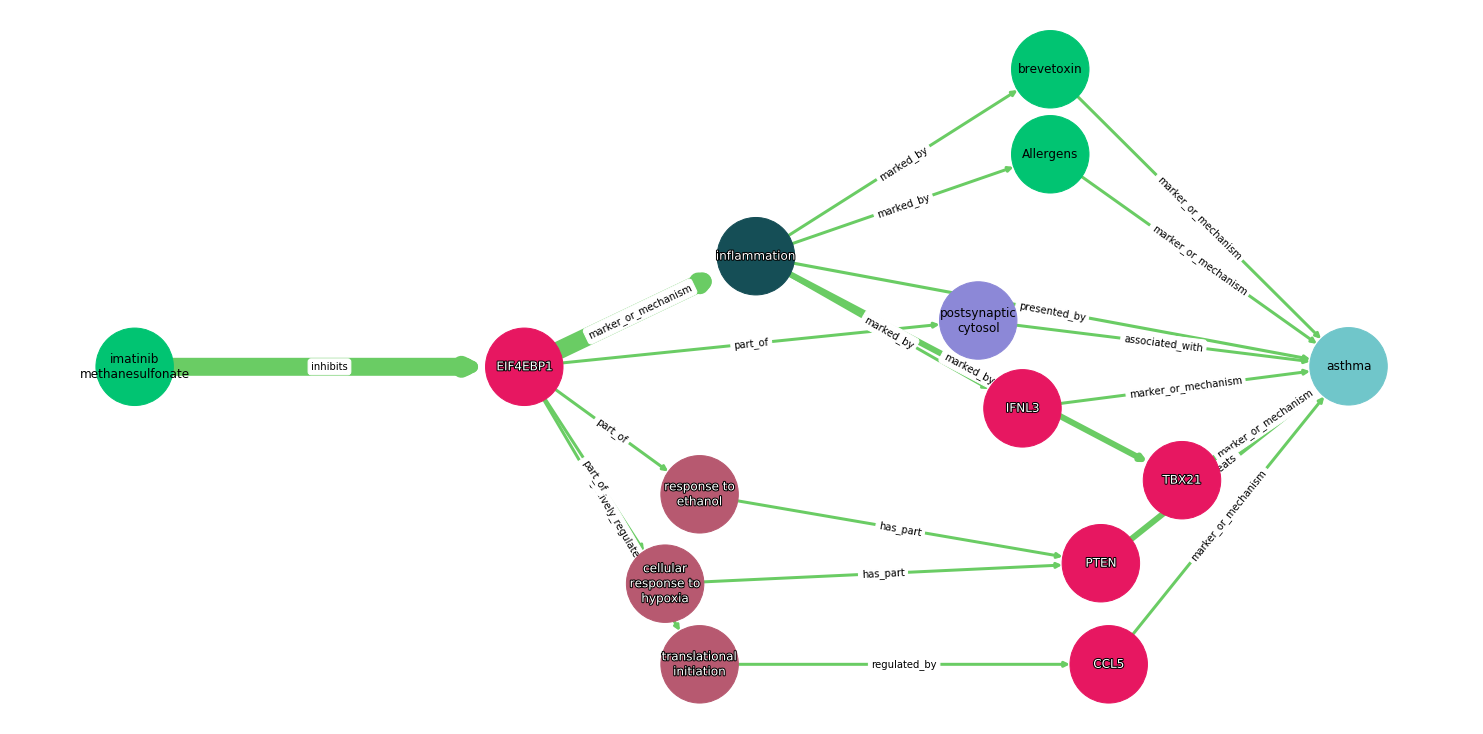

In [97]:
draw_top_paths(query_target(imat_asth, 'NCBIGene:1978'), 10, 'std_metric')

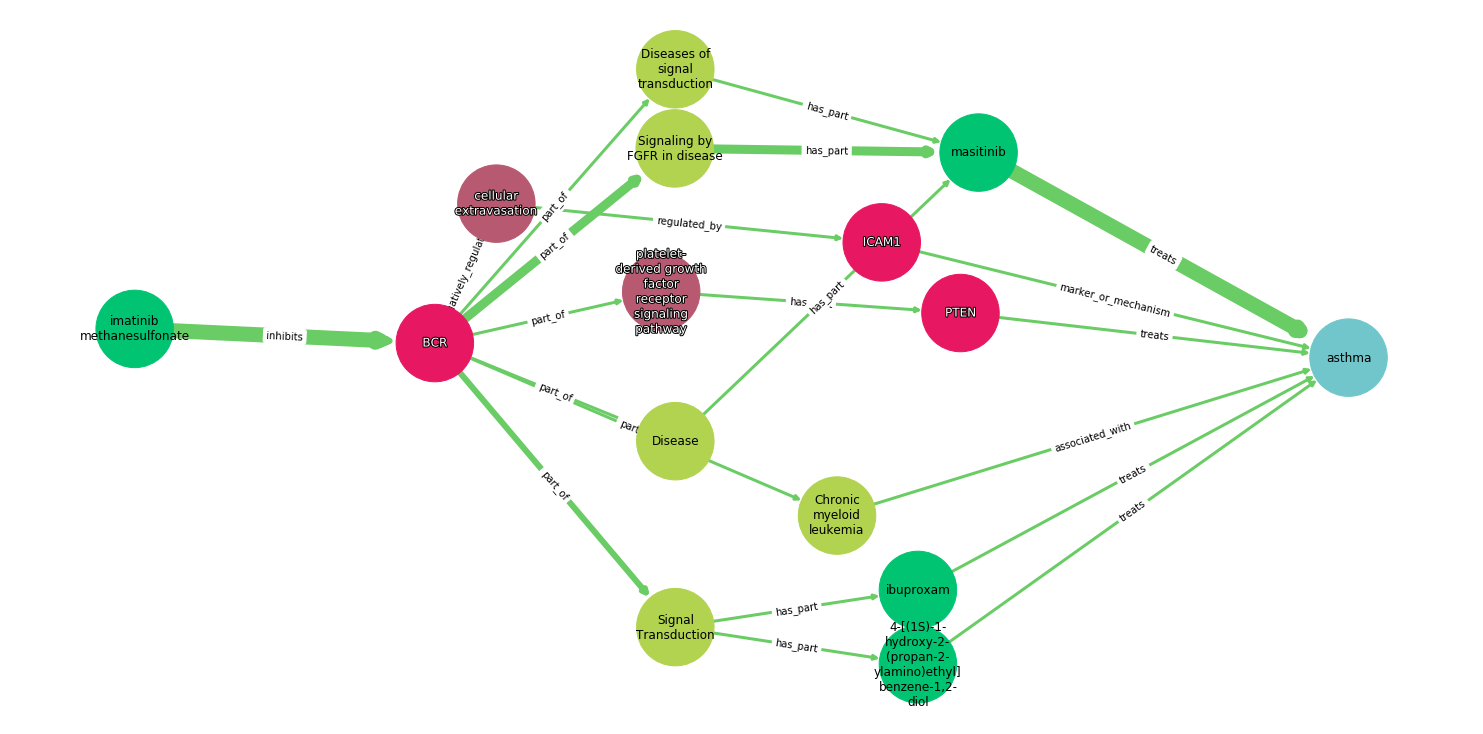

In [98]:
draw_top_paths(query_target(imat_asth, 'NCBIGene:613'), 10, 'std_metric')

In [99]:
ranks.head(10)

,node_id,model_metric,deg_sep,node_name,node_label
0,CHEBI:53636,1.128780,2,neomycin B sulfate,ChemicalSubstance
1,NCBIGene:5515,0.948534,1,PPP2CA,MacromolecularMachine
2,GO:0014827,0.827026,1,intestine smooth muscle contraction,BiologicalProcessOrActivity
3,NCBIGene:5728,0.809209,2,PTEN,MacromolecularMachine
4,GO:0070640,0.754601,1,vitamin D3 metabolic process,BiologicalProcessOrActivity
5,MESH:D007249,0.686585,2,inflammation,PhenotypicFeature
6,NCBIGene:217,0.663397,1,ALDH2,MacromolecularMachine
7,GO:0043306,0.609942,1,positive regulation of mast cell degranulation,BiologicalProcessOrActivity
8,CHEBI:63450,0.542866,2,masitinib,ChemicalSubstance
9,NCBIGene:2309,0.525292,2,FOXO3,MacromolecularMachine


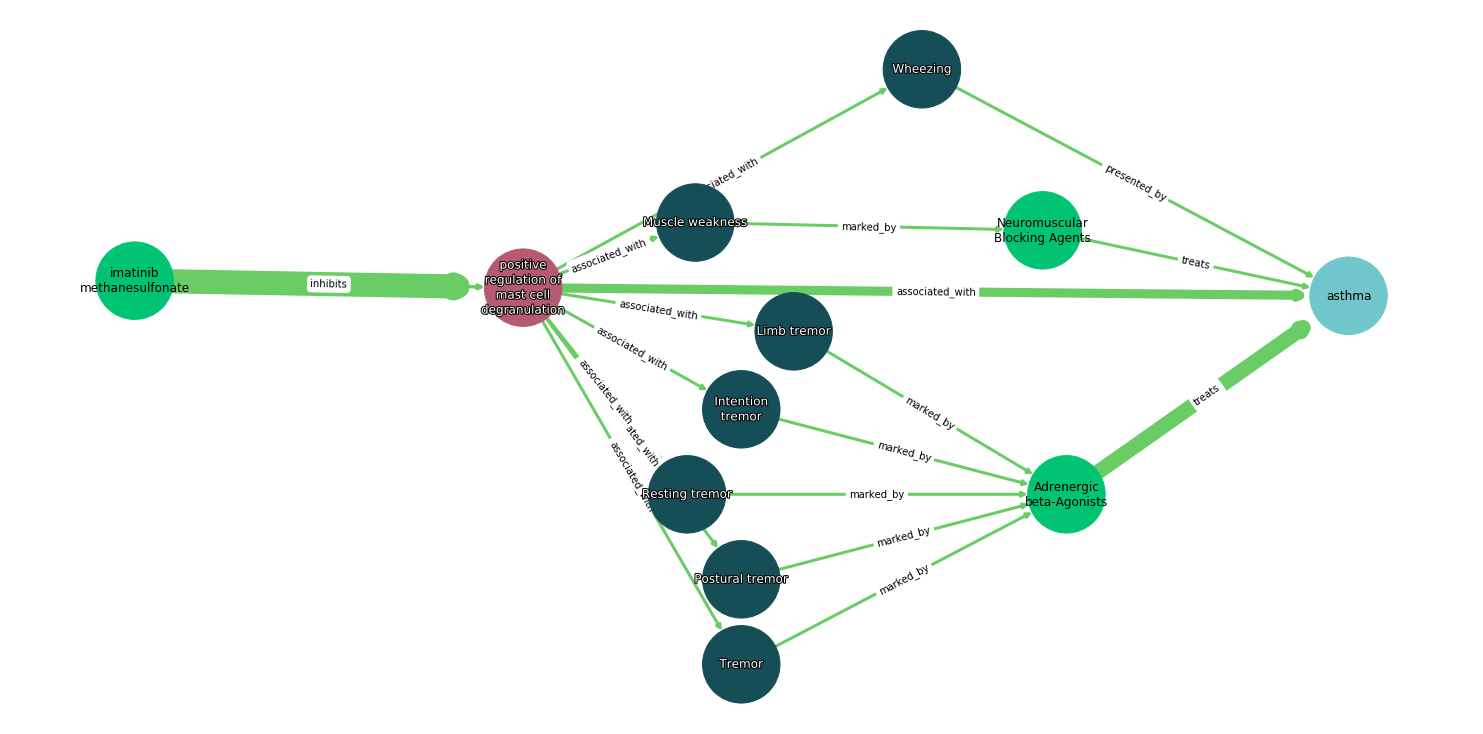

In [100]:
draw_top_paths(query_target(imat_asth, 'GO:0043306'), 10, 'std_metric')

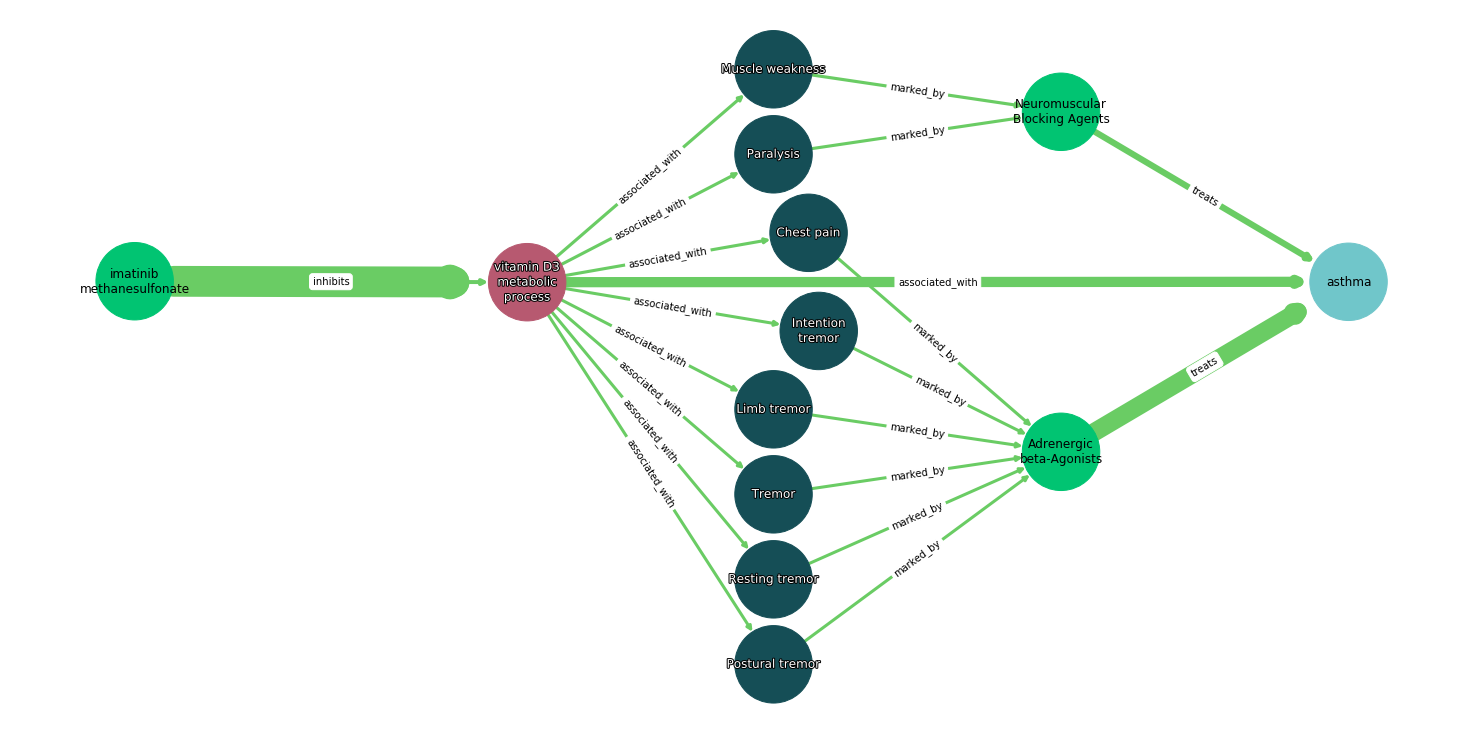

In [101]:
draw_top_paths(query_target(imat_asth, 'GO:0070640'))

In [102]:
ranks.query('node_id == @ckit')

,node_id,model_metric,deg_sep,node_name,node_label
84,NCBIGene:3815,0.08923,1,KIT,MacromolecularMachine


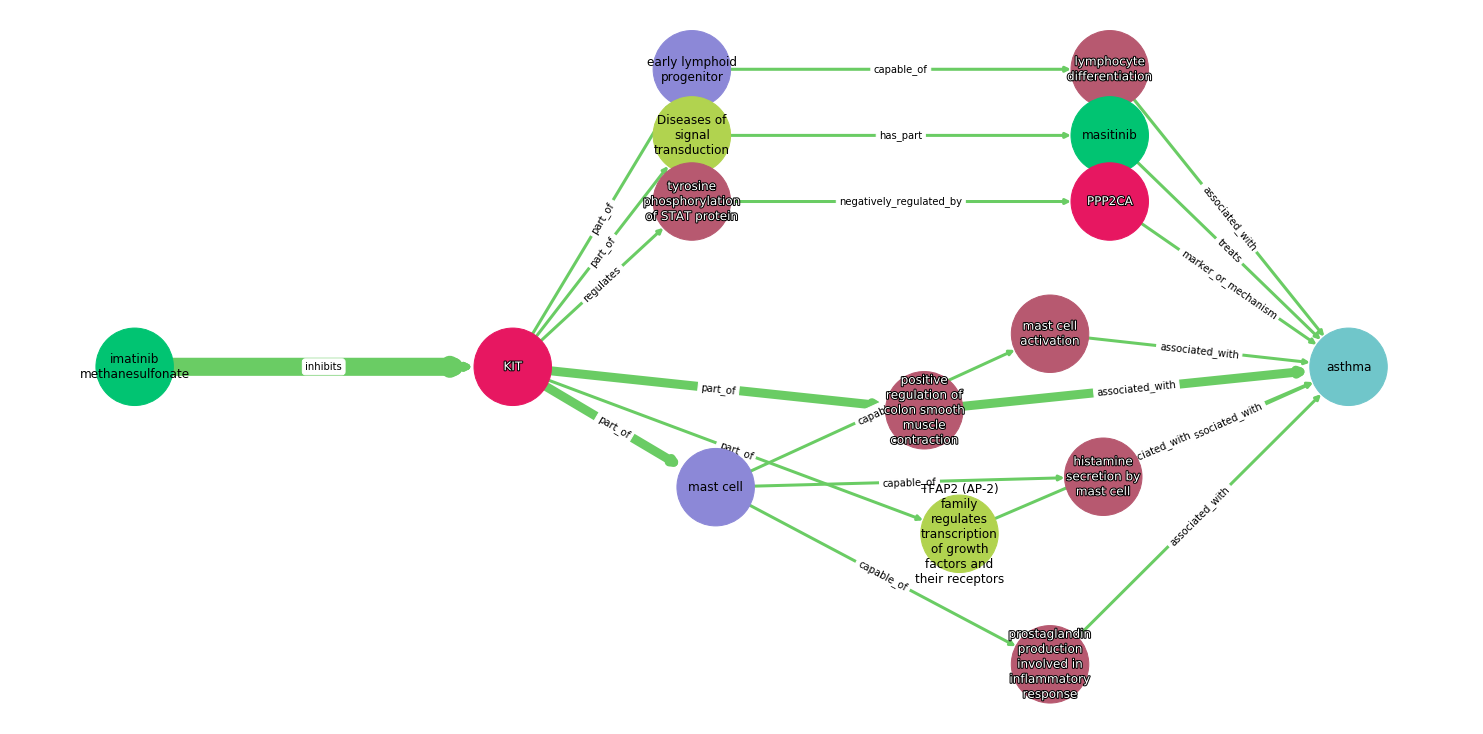

In [103]:
qid = 'NCBIGene:3815'
qr = pd.concat([query_target(imat_asth, qid), query_path_pos(imat_asth, qid, 2), query_path_pos(imat_asth, qid, 3)])
draw_top_paths(qr)

In [104]:
ranks.query('deg_sep != 1').head(10)

,node_id,model_metric,deg_sep,node_name,node_label
0,CHEBI:53636,1.128780,2,neomycin B sulfate,ChemicalSubstance
3,NCBIGene:5728,0.809209,2,PTEN,MacromolecularMachine
5,MESH:D007249,0.686585,2,inflammation,PhenotypicFeature
8,CHEBI:63450,0.542866,2,masitinib,ChemicalSubstance
9,NCBIGene:2309,0.525292,2,FOXO3,MacromolecularMachine
14,MESH:D000318,0.371375,3,Adrenergic beta-Agonists,ChemicalSubstance
15,MESH:D009466,0.365320,3,Neuromuscular Blocking Agents,ChemicalSubstance
17,MESH:D005938,0.344644,3,Glucocorticoids,ChemicalSubstance
18,CHEBI:3207,0.325681,2,budesonide,ChemicalSubstance
20,HP:0030828,0.295850,2,Wheezing,PhenotypicFeature


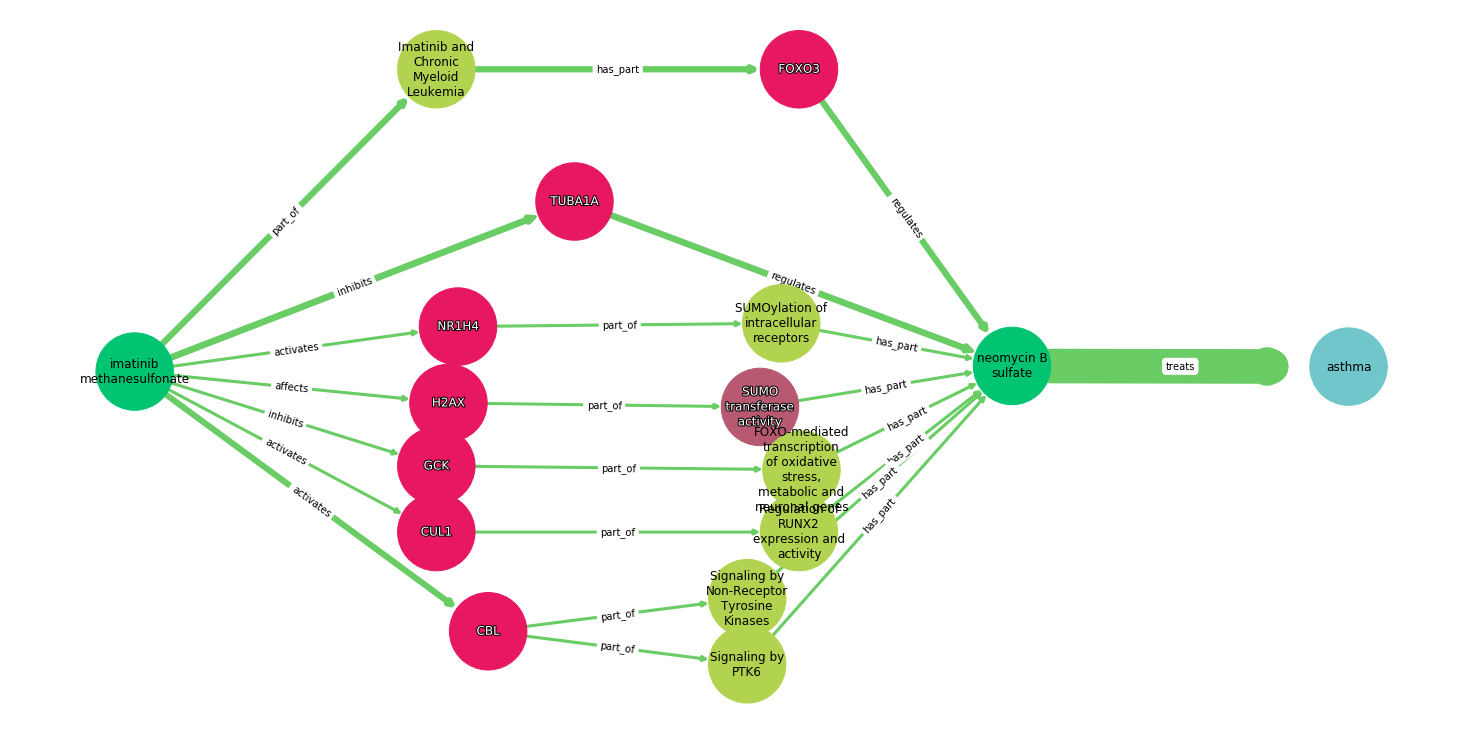

In [105]:
qr = pd.concat([query_path_pos(imat_asth, 'CHEBI:53636', 2), query_path_pos(imat_asth, 'CHEBI:53636', 3), query_path_pos(imat_asth, 'CHEBI:53636', 4)])

draw_top_paths(qr)

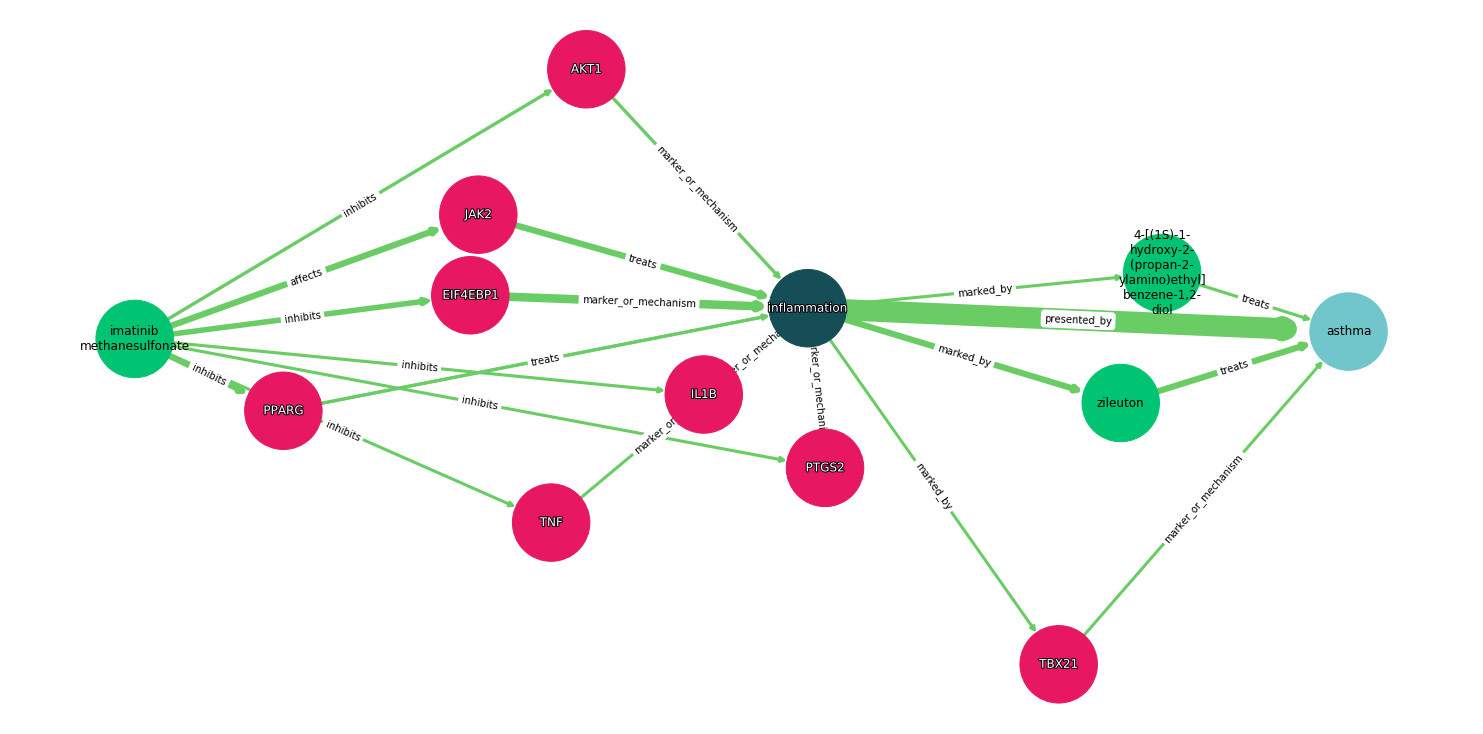

In [106]:
qid = 'MESH:D007249'
qr = pd.concat([query_target(imat_asth, qid), query_path_pos(imat_asth, qid, 2), query_path_pos(imat_asth, qid, 3)])
draw_top_paths(qr)

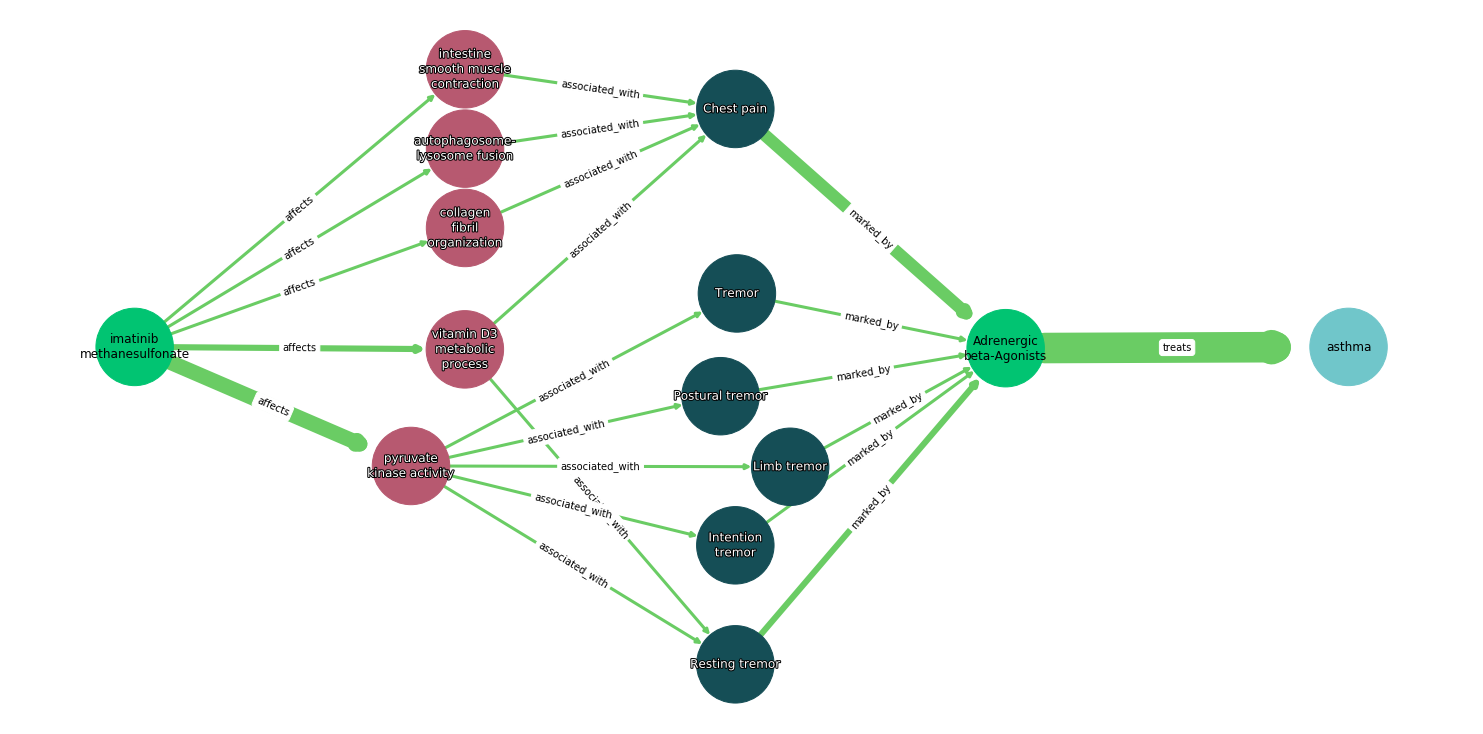

In [107]:
qid = 'MESH:D000318'
qr = pd.concat([query_target(imat_asth, qid), query_path_pos(imat_asth, qid, 2), query_path_pos(imat_asth, qid, 3)])
draw_top_paths(qr)

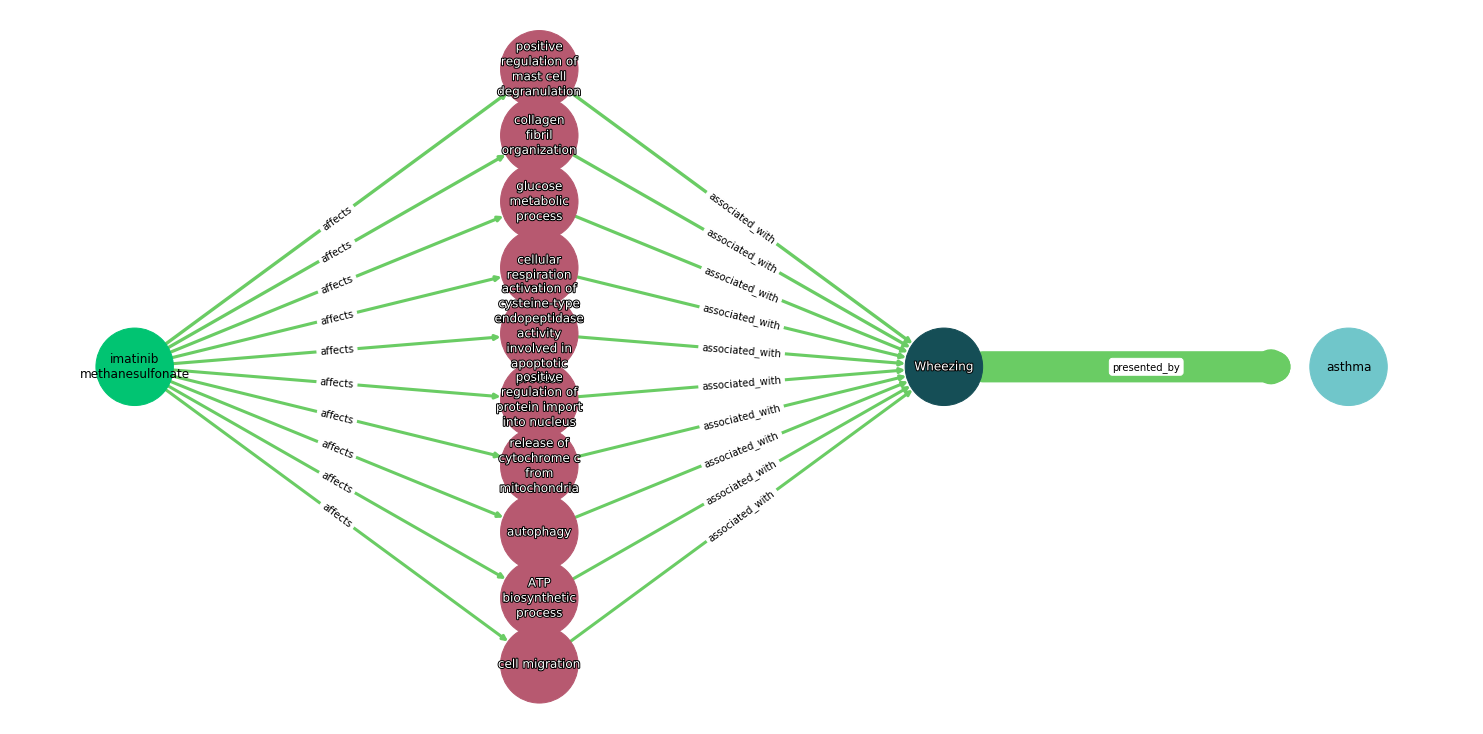

In [108]:
qid = 'HP:0030828'
qr = pd.concat([query_target(imat_asth, qid), query_path_pos(imat_asth, qid, 2), query_path_pos(imat_asth, qid, 3)])
draw_top_paths(qr)

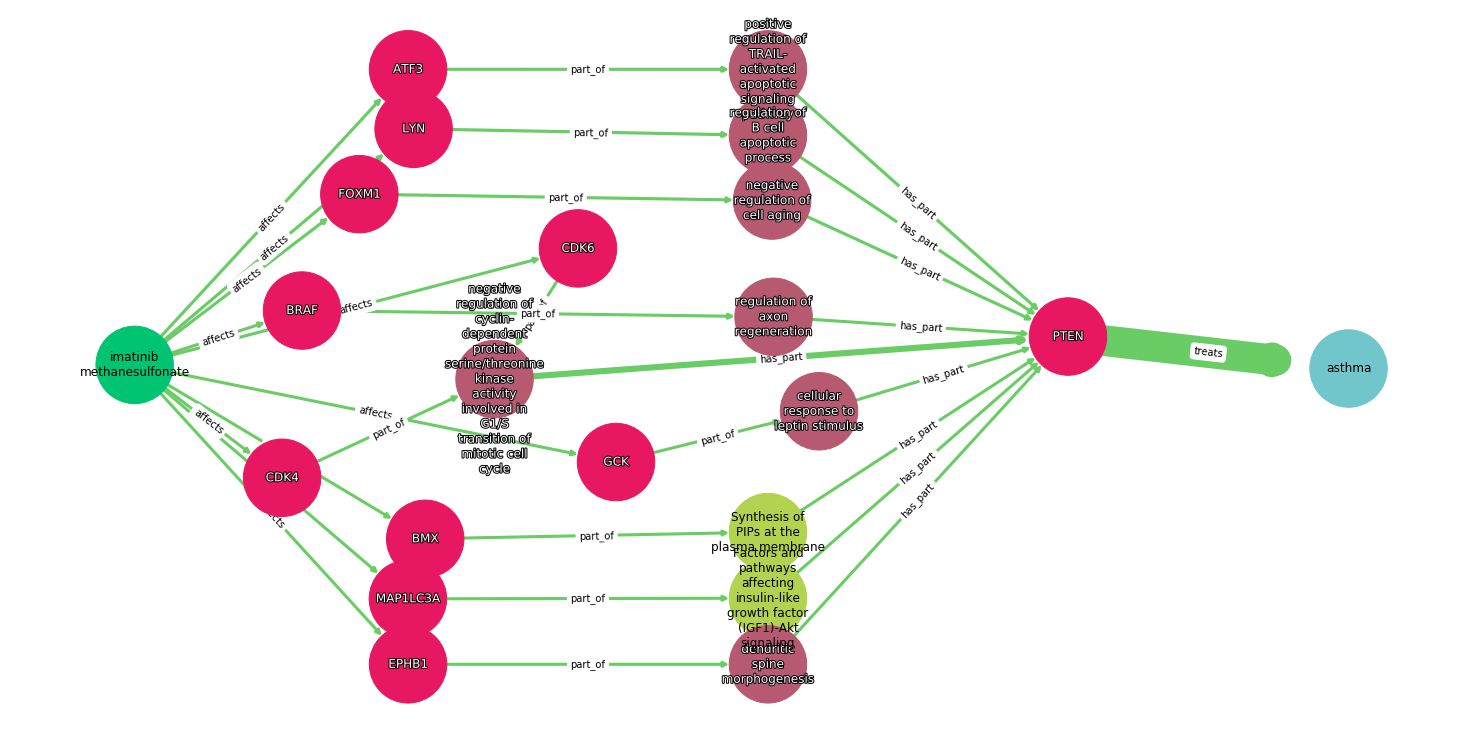

In [109]:
qid = 'NCBIGene:5728'
qr = pd.concat([query_target(imat_asth, qid), query_path_pos(imat_asth, qid, 2), query_path_pos(imat_asth, qid, 3)])
draw_top_paths(qr)

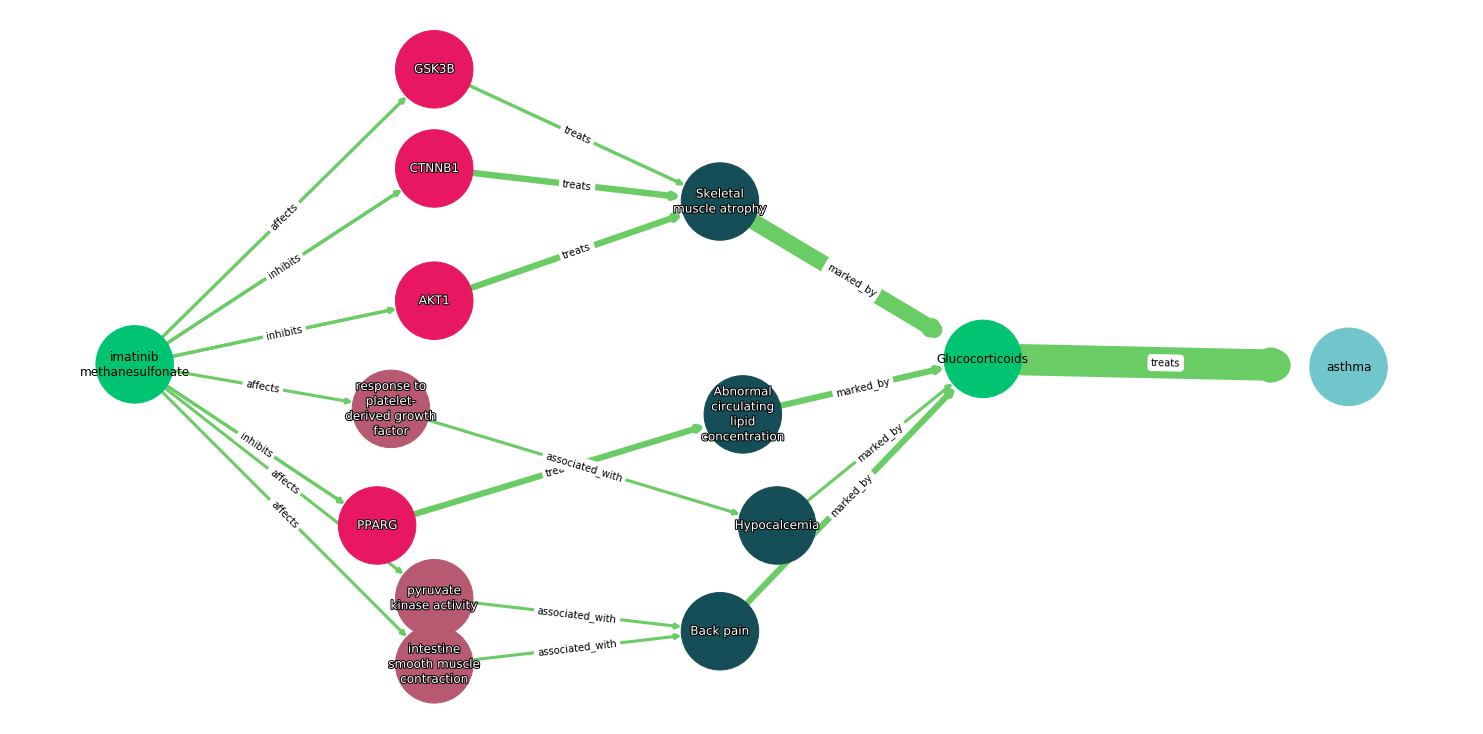

In [110]:
qid = 'MESH:D005938'
qr = pd.concat([query_target(imat_asth, qid), query_path_pos(imat_asth, qid, 2), query_path_pos(imat_asth, qid, 3)])
draw_top_paths(qr)